In [2]:
import autograd.numpy as np
import numpy.random as rnd
import matplotlib.pyplot as plt
import seaborn
import time
import matplotlib as mpl
import seaborn as sns
mpl.rcParams['figure.figsize'] = 16, 9
mpl.rcParams['figure.dpi'] = 400


# Example, Simple Linear Model

In [3]:
def linear_model(x, weights):
    return weights[0] + np.sum(x*weights[1:])

xSet = [rnd.normal(size = 4) for i in xrange(50)]


optw = rnd.randint(-10, 10, size = 5).astype('float64')
ySet = np.array([linear_model(x, optw) for x in xSet]) + rnd.normal(size = len(xSet))
print(optw)

[ 6. -4.  1.  3.  3.]


In [4]:
S = zip(xSet, ySet)

In [5]:
S[:6]

[(array([ 0.66161846, -0.54236676, -1.23689745, -0.67787146]),
  -1.463997418909371),
 (array([ 1.06297296,  0.25503615,  0.12569831, -0.44592419]),
  0.86069074795032019),
 (array([ 0.57145281, -0.48371009, -0.05086953,  1.47342572]),
  7.1002866075442537),
 (array([ 0.46186146,  0.78003907, -0.76866246, -0.77022089]),
  -0.01608046774566757),
 (array([ 0.4755736 , -0.59851598,  1.43725796,  0.87073853]),
  8.7381015476005253),
 (array([-0.55057739,  1.19368667, -0.43194325, -2.46258718]),
  0.63894825831087498)]

In [6]:
theta = rnd.randint(-10, 10, size = 5) + rnd.normal(size = 5)
# At first sight, we can go with a simple for loop over all samples - but this is not the most effcient way:
# we should use the dot product between the data matrix and the weight in this simple case
predictedY = [linear_model(x, theta) for x in xSet]
# Print the error
print np.sum((predictedY - ySet)**2)

12759.4051581


In [7]:
# The objective function measures the error of our prediction for a given sample set S
def objective_function(theta, S):
    return np.sum([(linear_model(x, theta) - y)**2 for x,y in S]) # + np.sqrt(np.sum(w**2))

# The objective function measures the error of our prediction for a given sample set S
def objective_function(theta, S):
    error = 0.
    for x,y in S:
        error += (linear_model(x, theta) - y)**2
    return error

# evaluate the error on a random guess
objective_function(theta, S)

12759.405158052505

In [10]:
def objective_function_gradient_2(theta, S):
    gradient = np.zeros_like(theta)
    for x,y in S:
        _x = np.append(1, x)
        gradient += 2 * _x * (linear_model(x, theta) - y)
    return gradient


# Manual Differentiation
# Ex  = (f(x,w) - y)^2 = f(x,w)^2 - 2*f(x,w)*y + y^2
# Ex/dw = (f(x,w)^2 - 2*f(x,w)*y)/dw    | f(x) = g(h(x)) =>  f'(x) = g'(h(x))h'(x)
#       = 2 * f(x,w) * (f(x,w)/dw) - 2*(f(x,w)/dw)*y
#   where 
#     f(x,w)/dw = (1, x_1, ... x_d)
def objective_function_gradient(theta, S):
    return np.sum([2*(linear_model(x, theta)*np.append(1, x)) - 
                   2* np.append(1, x)*y for x,y in S], axis = 0)


    
# Automatic Differentiation !
from autograd import grad
objective_function_gradient_auto = grad(objective_function)

In [11]:
print objective_function_gradient(theta, S)
print objective_function_gradient_2(theta, S)
print objective_function_gradient_auto(theta, S)

[ -912.92639511  -166.20120254   293.92311846  -697.02670799 -1027.77414576]
[ -912.92639511  -166.20120254   293.92311846  -697.02670799 -1027.77414576]
[ -912.92639511  -166.20120254   293.92311846  -697.02670799 -1027.77414576]


In [12]:
# There is however a disatvantage:
%timeit objective_function_gradient(theta, S)
%timeit objective_function_gradient_auto(theta, S)

100 loops, best of 3: 3.33 ms per loop
10 loops, best of 3: 25 ms per loop


# Gradient Descent

## Batch Gradient Descent

Batch Gradient Descent takes all data into consideration

In [412]:
theta = rnd.normal(size = 5)*rnd.randint(-50, 50, size = 5)# + rnd.normal(size = 5)*50
error = [objective_function(theta, S)]
gradientNorm = list()
gradient_fun = objective_function_gradient
learningRate = 0.001
maxIter = 1000

t = time.time()
condition = True
niter = 0
while condition:
    # Batch gradient computes gradient based on the whole data set
    gradient = gradient_fun(theta, S)
    theta -= learningRate*gradient
    niter += 1
    error.append(objective_function(theta, S))
    gradientNorm.append(np.linalg.norm(gradient))
    condition = not (np.isclose(0., np.linalg.norm(gradient)) or niter > maxIter)
print 'Computed %d iterations in %s seconds.' % (niter, (time.time() - t))

Computed 356 iterations in 1.72300004959 seconds.


In [413]:
print(theta)
print(optw)
print 'Objective at theta %f and at orginal weights %f' % (objective_function(theta, S), objective_function(optw, S))
print 'Gradient at theta: %.16f' % np.linalg.norm(gradient_fun(theta, S))

[-2.00127602  1.11050317  3.79647762  9.05509407  6.93406601]
[-2.  1.  4.  9.  7.]
Objective at theta 36.919757 and at orginal weights 39.473233
Gradient at theta: 0.0000000088528566


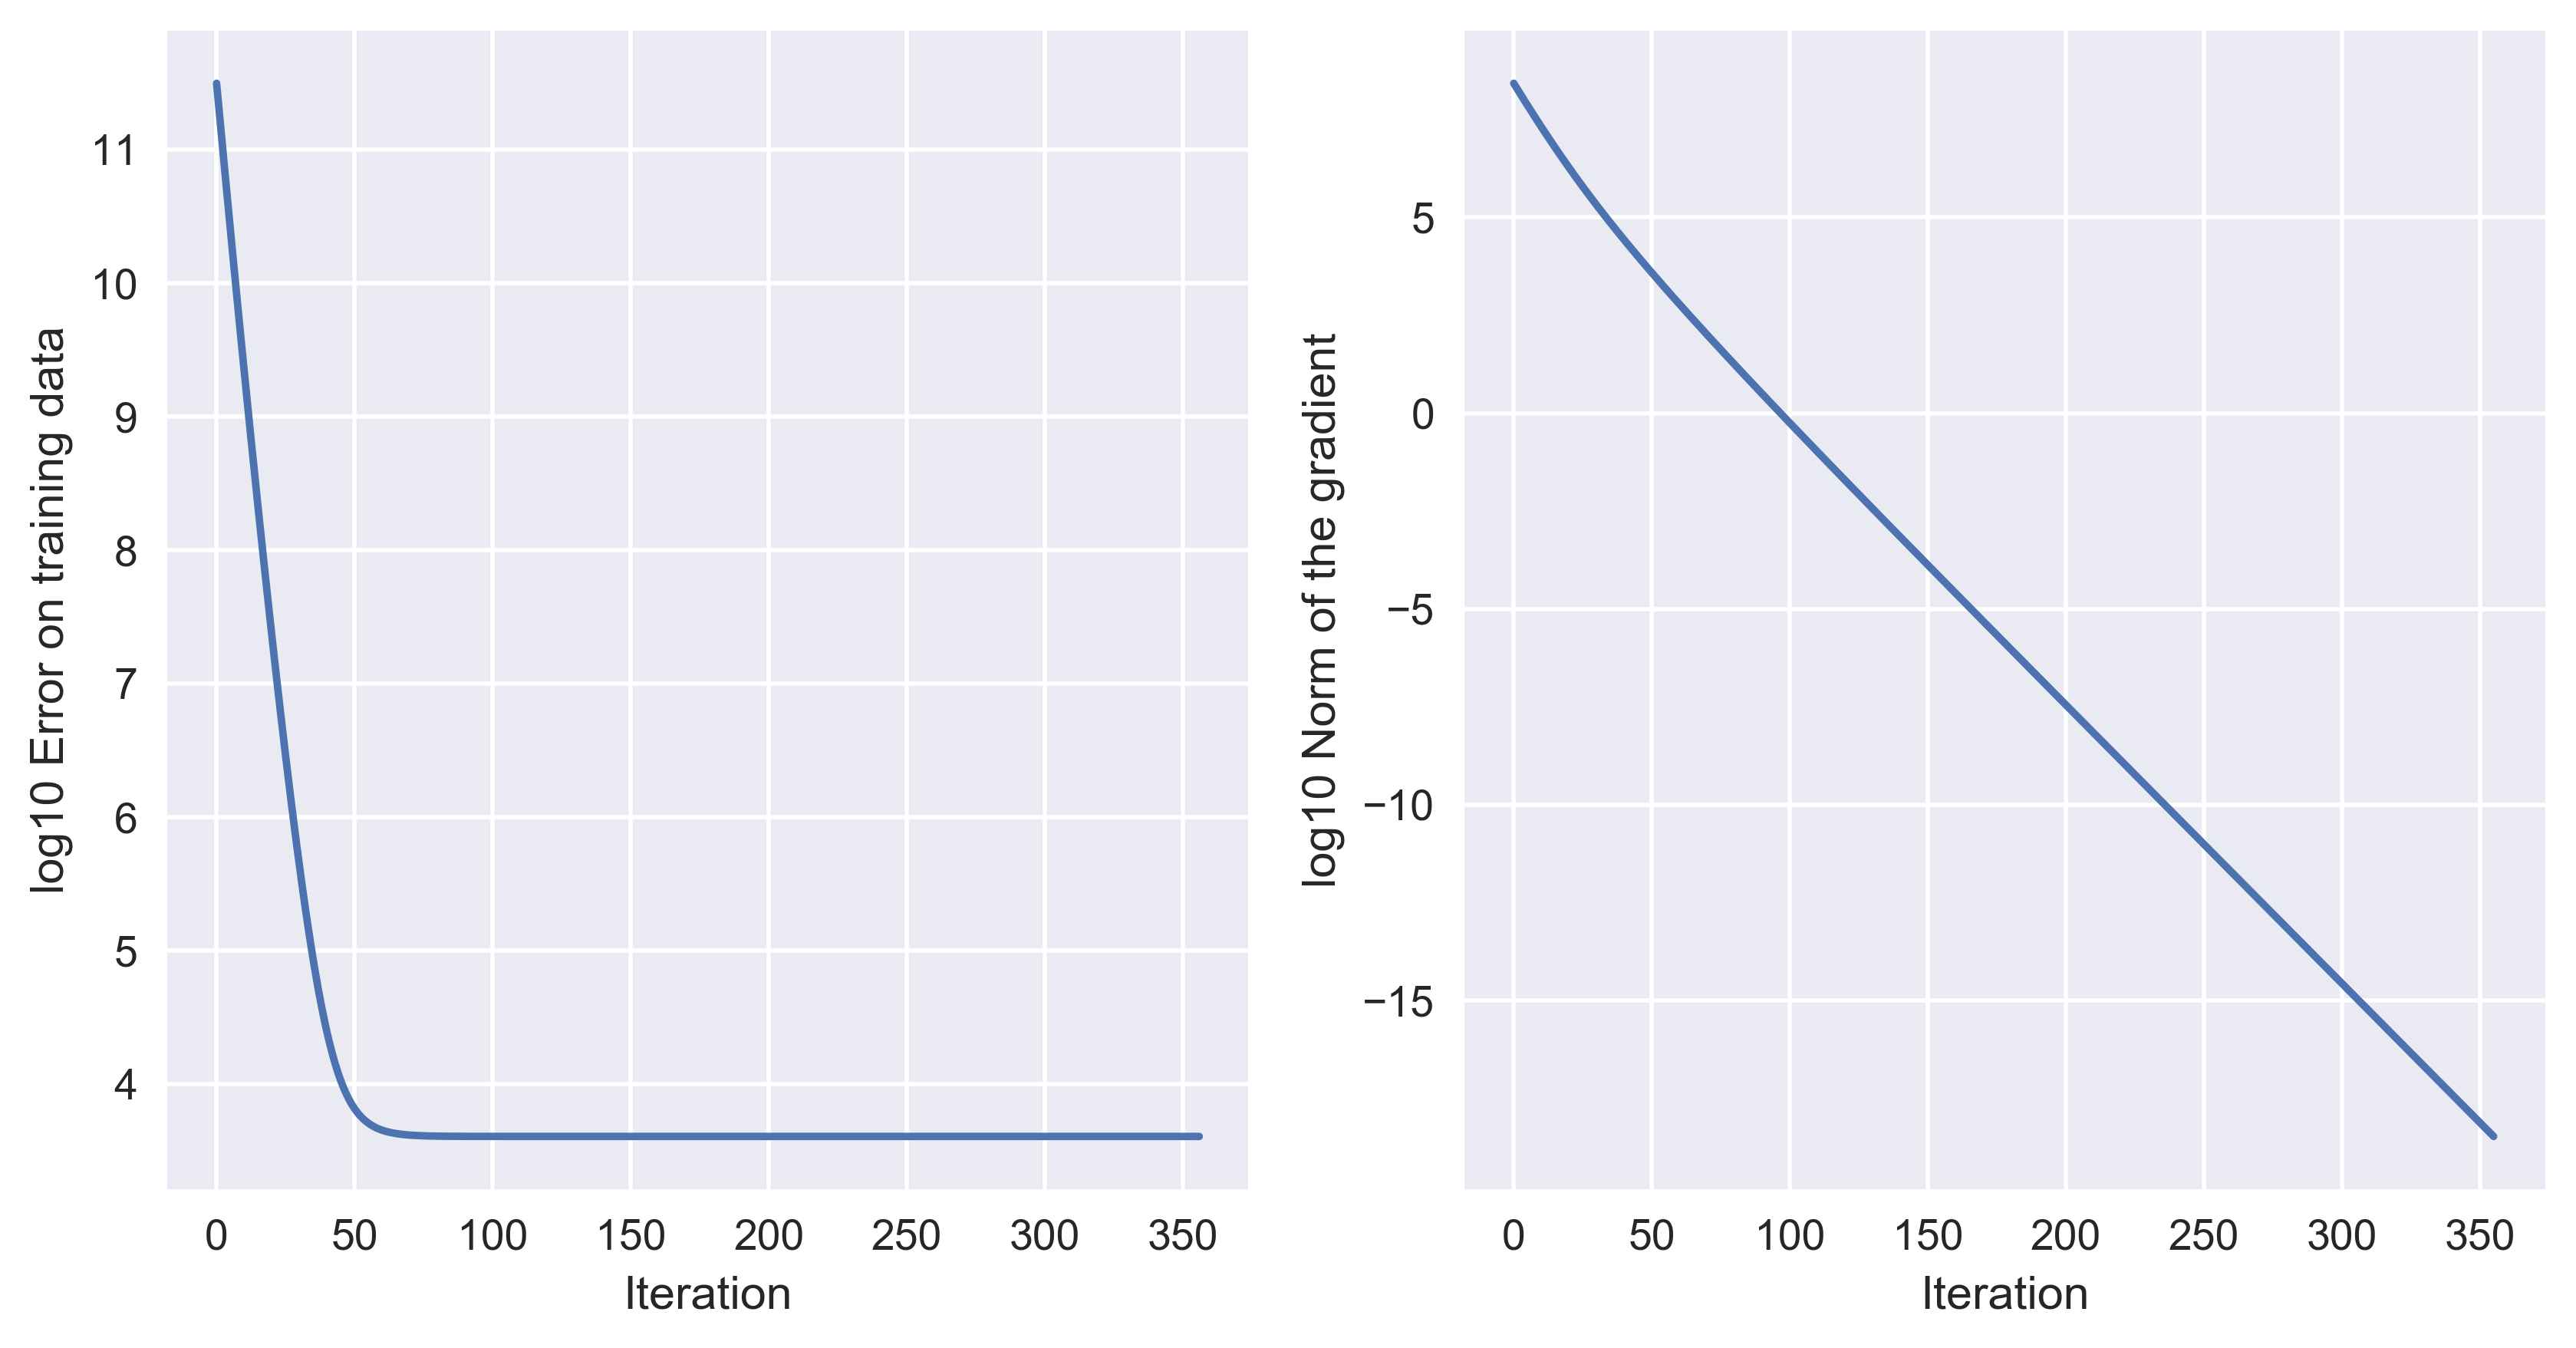

In [419]:
f, axes = plt.subplots(1, 2, sharex=True, sharey=False, figsize=(10, 5))
axes[0].plot(np.log(error))
axes[0].set_ylabel('log10 Error on training data')
axes[0].set_xlabel('Iteration')
axes[1].plot(np.log(gradientNorm))
axes[1].set_ylabel('log10 Norm of the gradient')
axes[1].set_xlabel('Iteration')
plt.show()

## Stochastic gradient descent 

Stochastic Gradient Descent takes only single samples when computing gradients. The norm of the gradient will like not be zero when checking terminal condition.

In [430]:
theta = rnd.normal(size = 5)*rnd.randint(-50, 50, size = 5)# + rnd.normal(size = 5)*50
error = [objective_function(theta, S)]
localerror = list()
gradientNorm = list()
gradient_fun = objective_function_gradient
learningRate = 0.001
maxIter = 350

t = time.time()
condition = True
niter = 0
while condition:
    for j in xrange(len(S)):
        _S = S[j:j+1]
        gradient = gradient_fun(theta, _S)
        theta -= learningRate*gradient
        localerror.append(objective_function(theta, _S))
    error.append(objective_function(theta, S))
    gradientNorm.append(np.linalg.norm(gradient))
    niter += 1
    condition = not (np.isclose(0., np.linalg.norm(gradient)) or niter > maxIter)
print 'Computed %d iterations in %s seconds.' % (niter, (time.time() - t))

Computed 351 iterations in 2.70500016212 seconds.


[-1.99730926  1.10993265  3.79819003  9.06208354  6.93939679]
[-2.  1.  4.  9.  7.]
Objective at theta 36.925245 and at orginal weights 39.473233
Gradient at theta: 1.1284361012949111


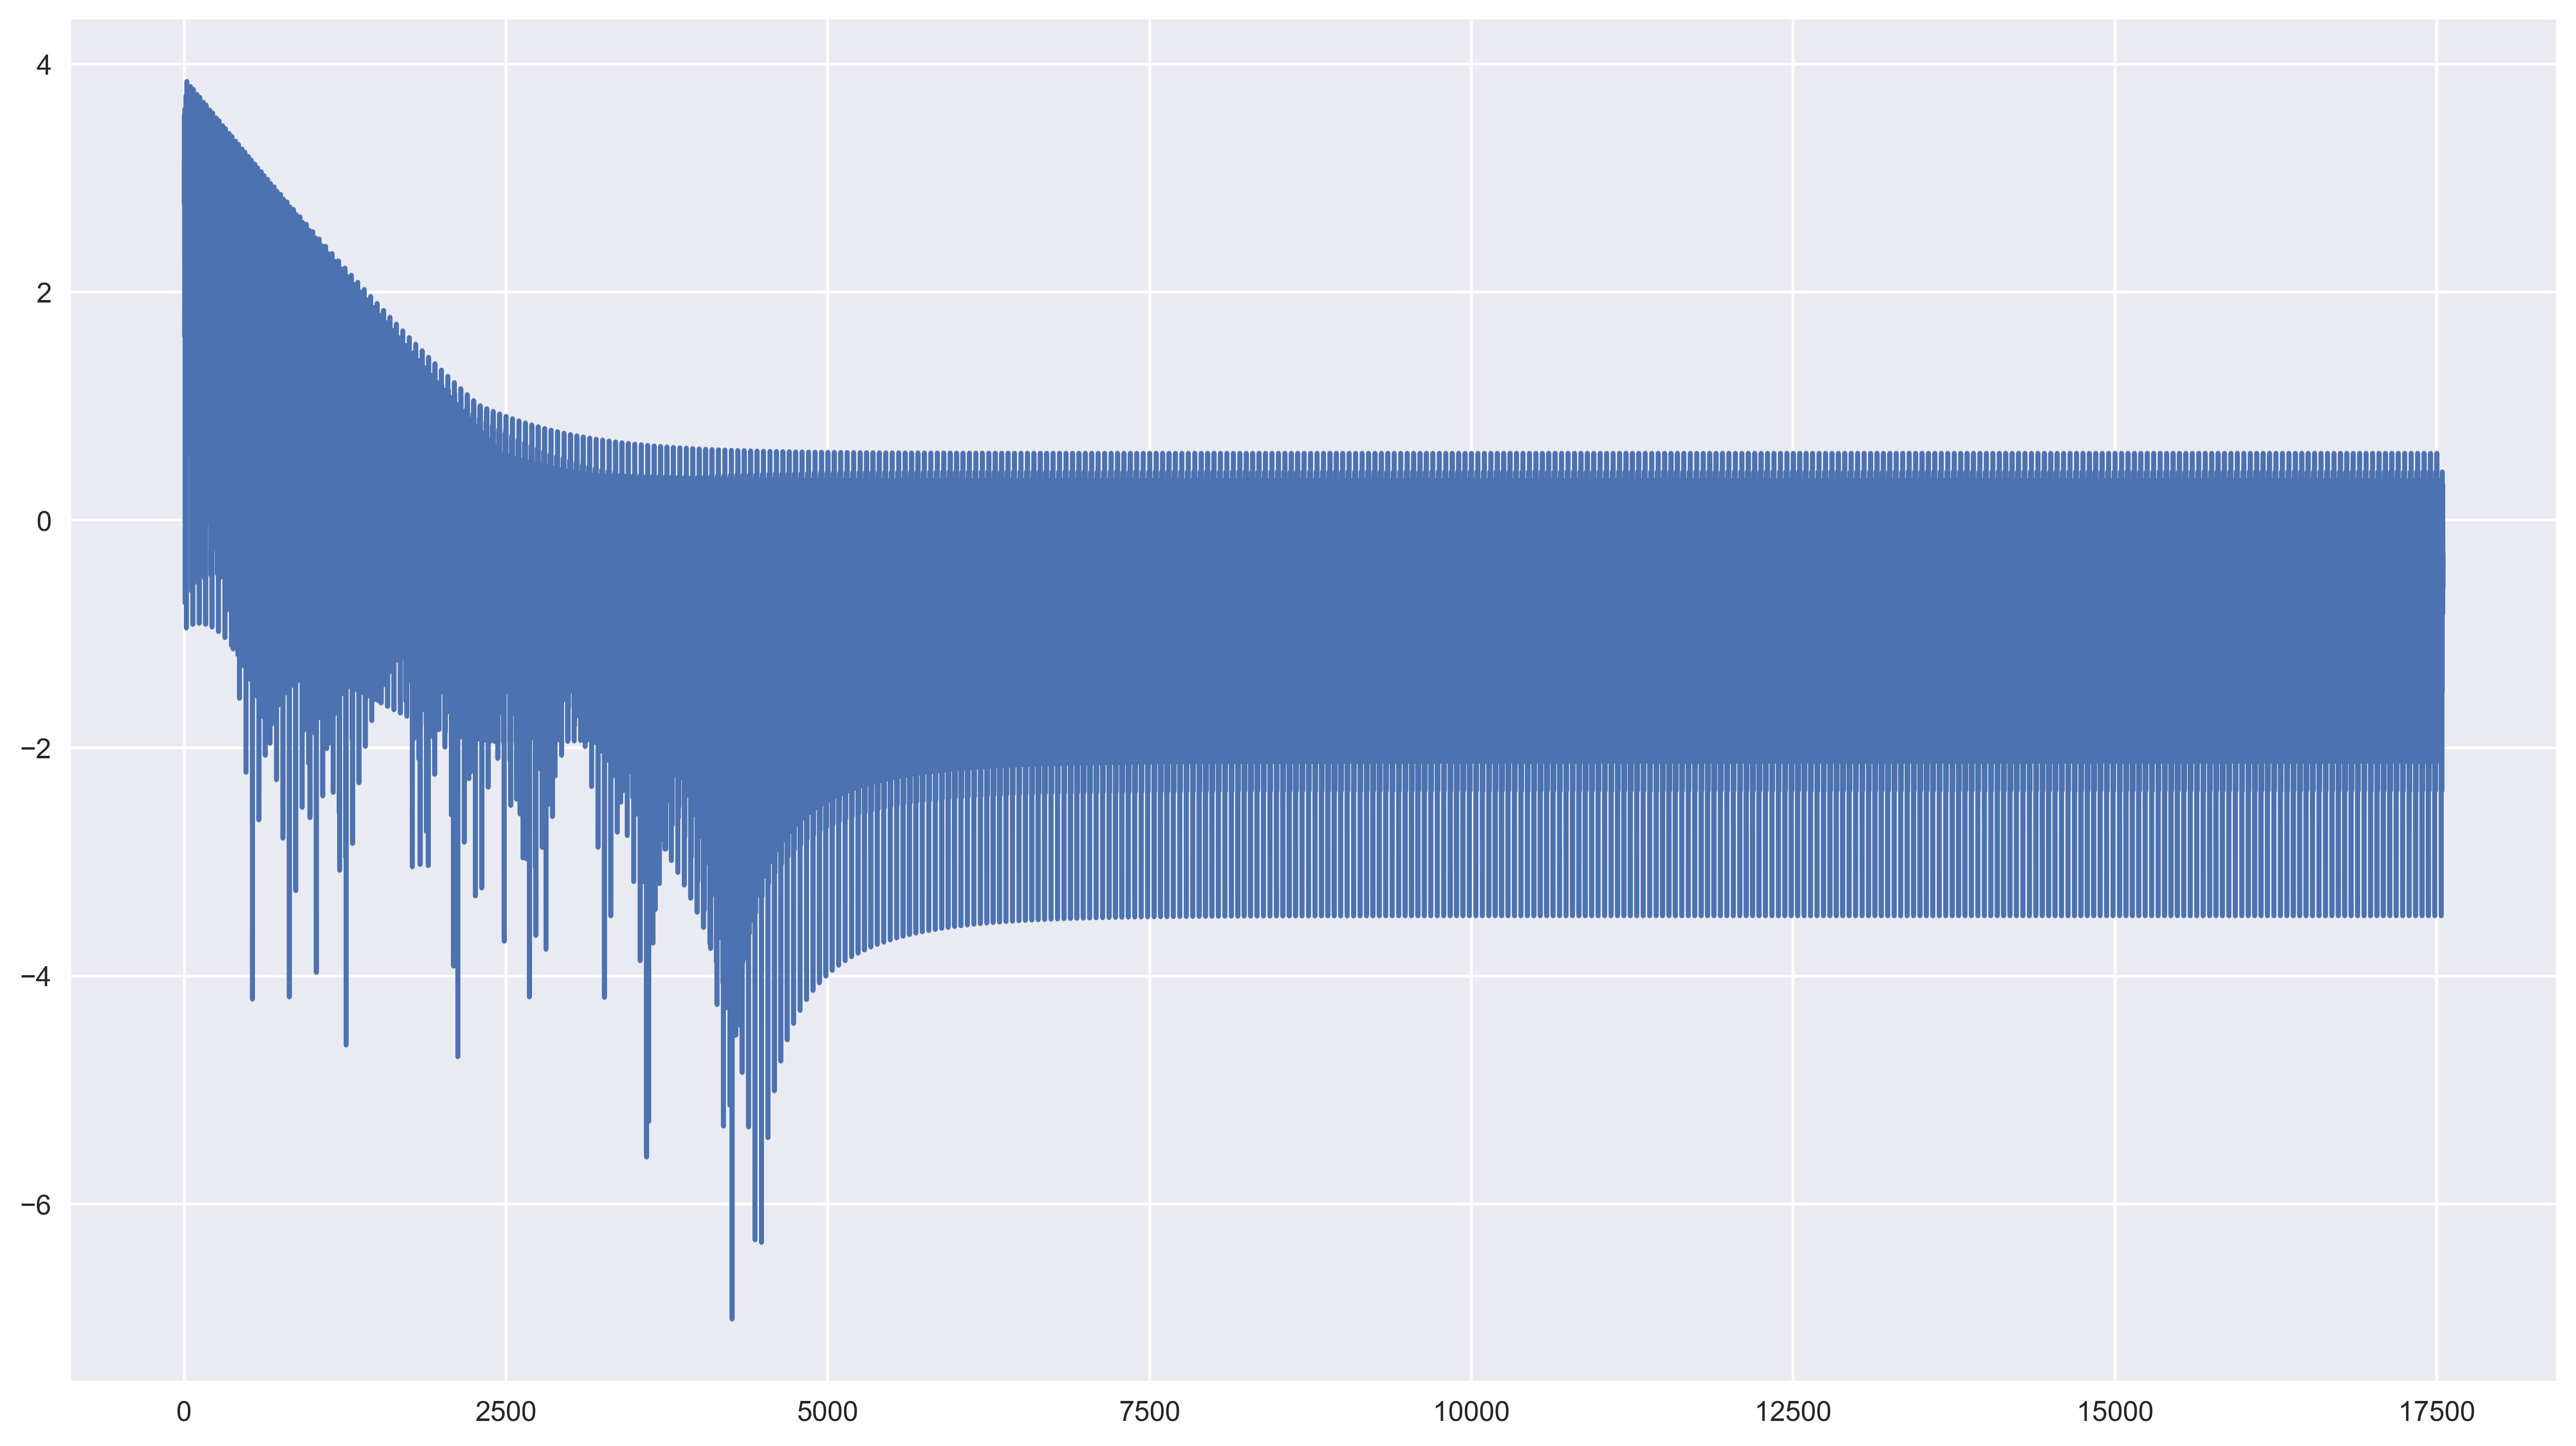

In [431]:
print(theta)
print(optw)
print 'Objective at theta %f and at orginal weights %f' % (objective_function(theta, S), objective_function(optw, S))
print 'Gradient at theta: %.16f' % np.linalg.norm(gradient_fun(theta, S))
plt.plot(np.log10(localerror))
plt.show()

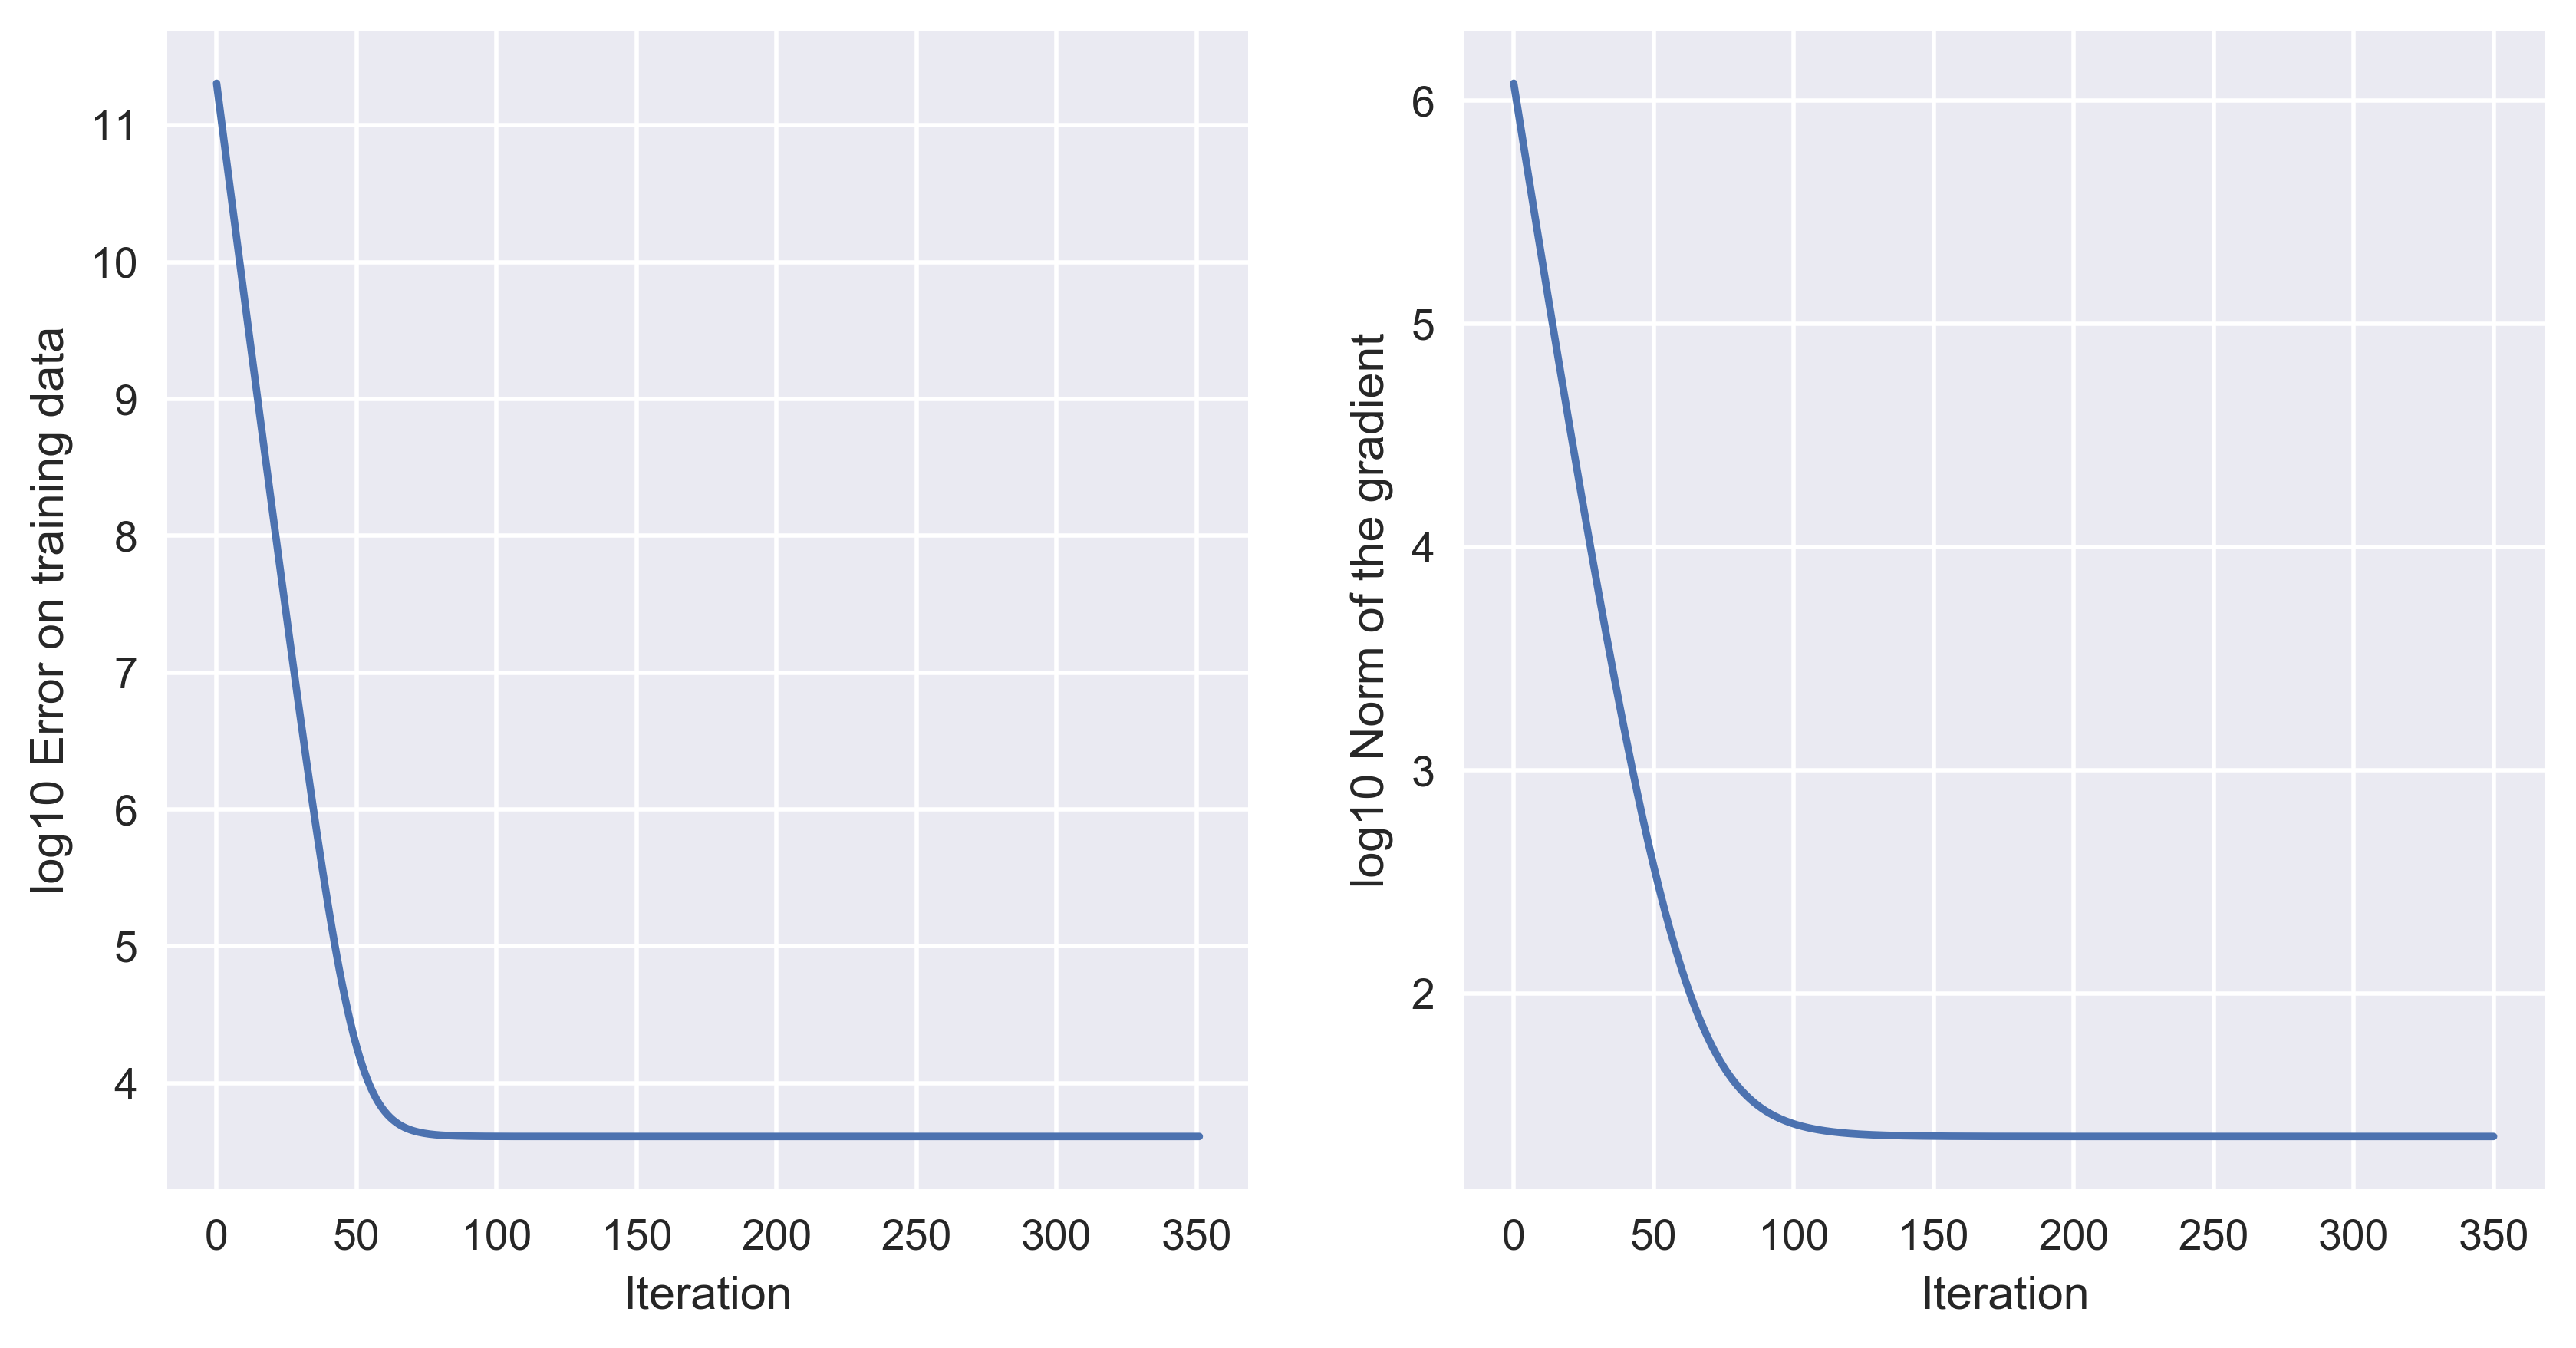

In [432]:
f, axes = plt.subplots(1, 2, sharex=True, sharey=False, figsize=(10, 5))
axes[0].plot(np.log(error))
axes[0].set_ylabel('log10 Error on training data')
axes[0].set_xlabel('Iteration')
axes[1].plot(np.log(gradientNorm))
axes[1].set_ylabel('log10 Norm of the gradient')
axes[1].set_xlabel('Iteration')
plt.show()

## Mini-Batch Gradient Descent

This methods only considers small batches of data. The term epoch refers to the number of time whole dataset has been seen.

In [463]:
theta = rnd.normal(size = 5)*rnd.randint(-50, 50, size = 5)# + rnd.normal(size = 5)*50
error = [objective_function(theta, S)]
localerror = list()
gradientNorm = list()
gradient_fun = objective_function_gradient
learningRate = 0.005
batchSize = 32
maxIter = 100

t = time.time()
for epoch in xrange(350):
    mu = learningRate/(1+0.005*epoch)
    rnd.shuffle(S)    
    batches = [S[i:i + batchSize] for i in xrange(0, len(S), batchSize)]
    for _S in batches:
        gradient = gradient_fun(theta, _S)
        theta -= mu*gradient
        localerror.append(objective_function(theta, _S))
    error.append(objective_function(theta, S))
    gradientNorm.append(np.linalg.norm(gradient))

print 'Computed in %s seconds' % (time.time() - t)

Computed in 1.8710000515 seconds


[-2.00209804  1.11140065  3.79658959  9.05510082  6.93477305]
[-2.  1.  4.  9.  7.]
Objective at theta 36.919845 and at orginal weights 39.473233
Gradient at theta: 0.1260624472941930


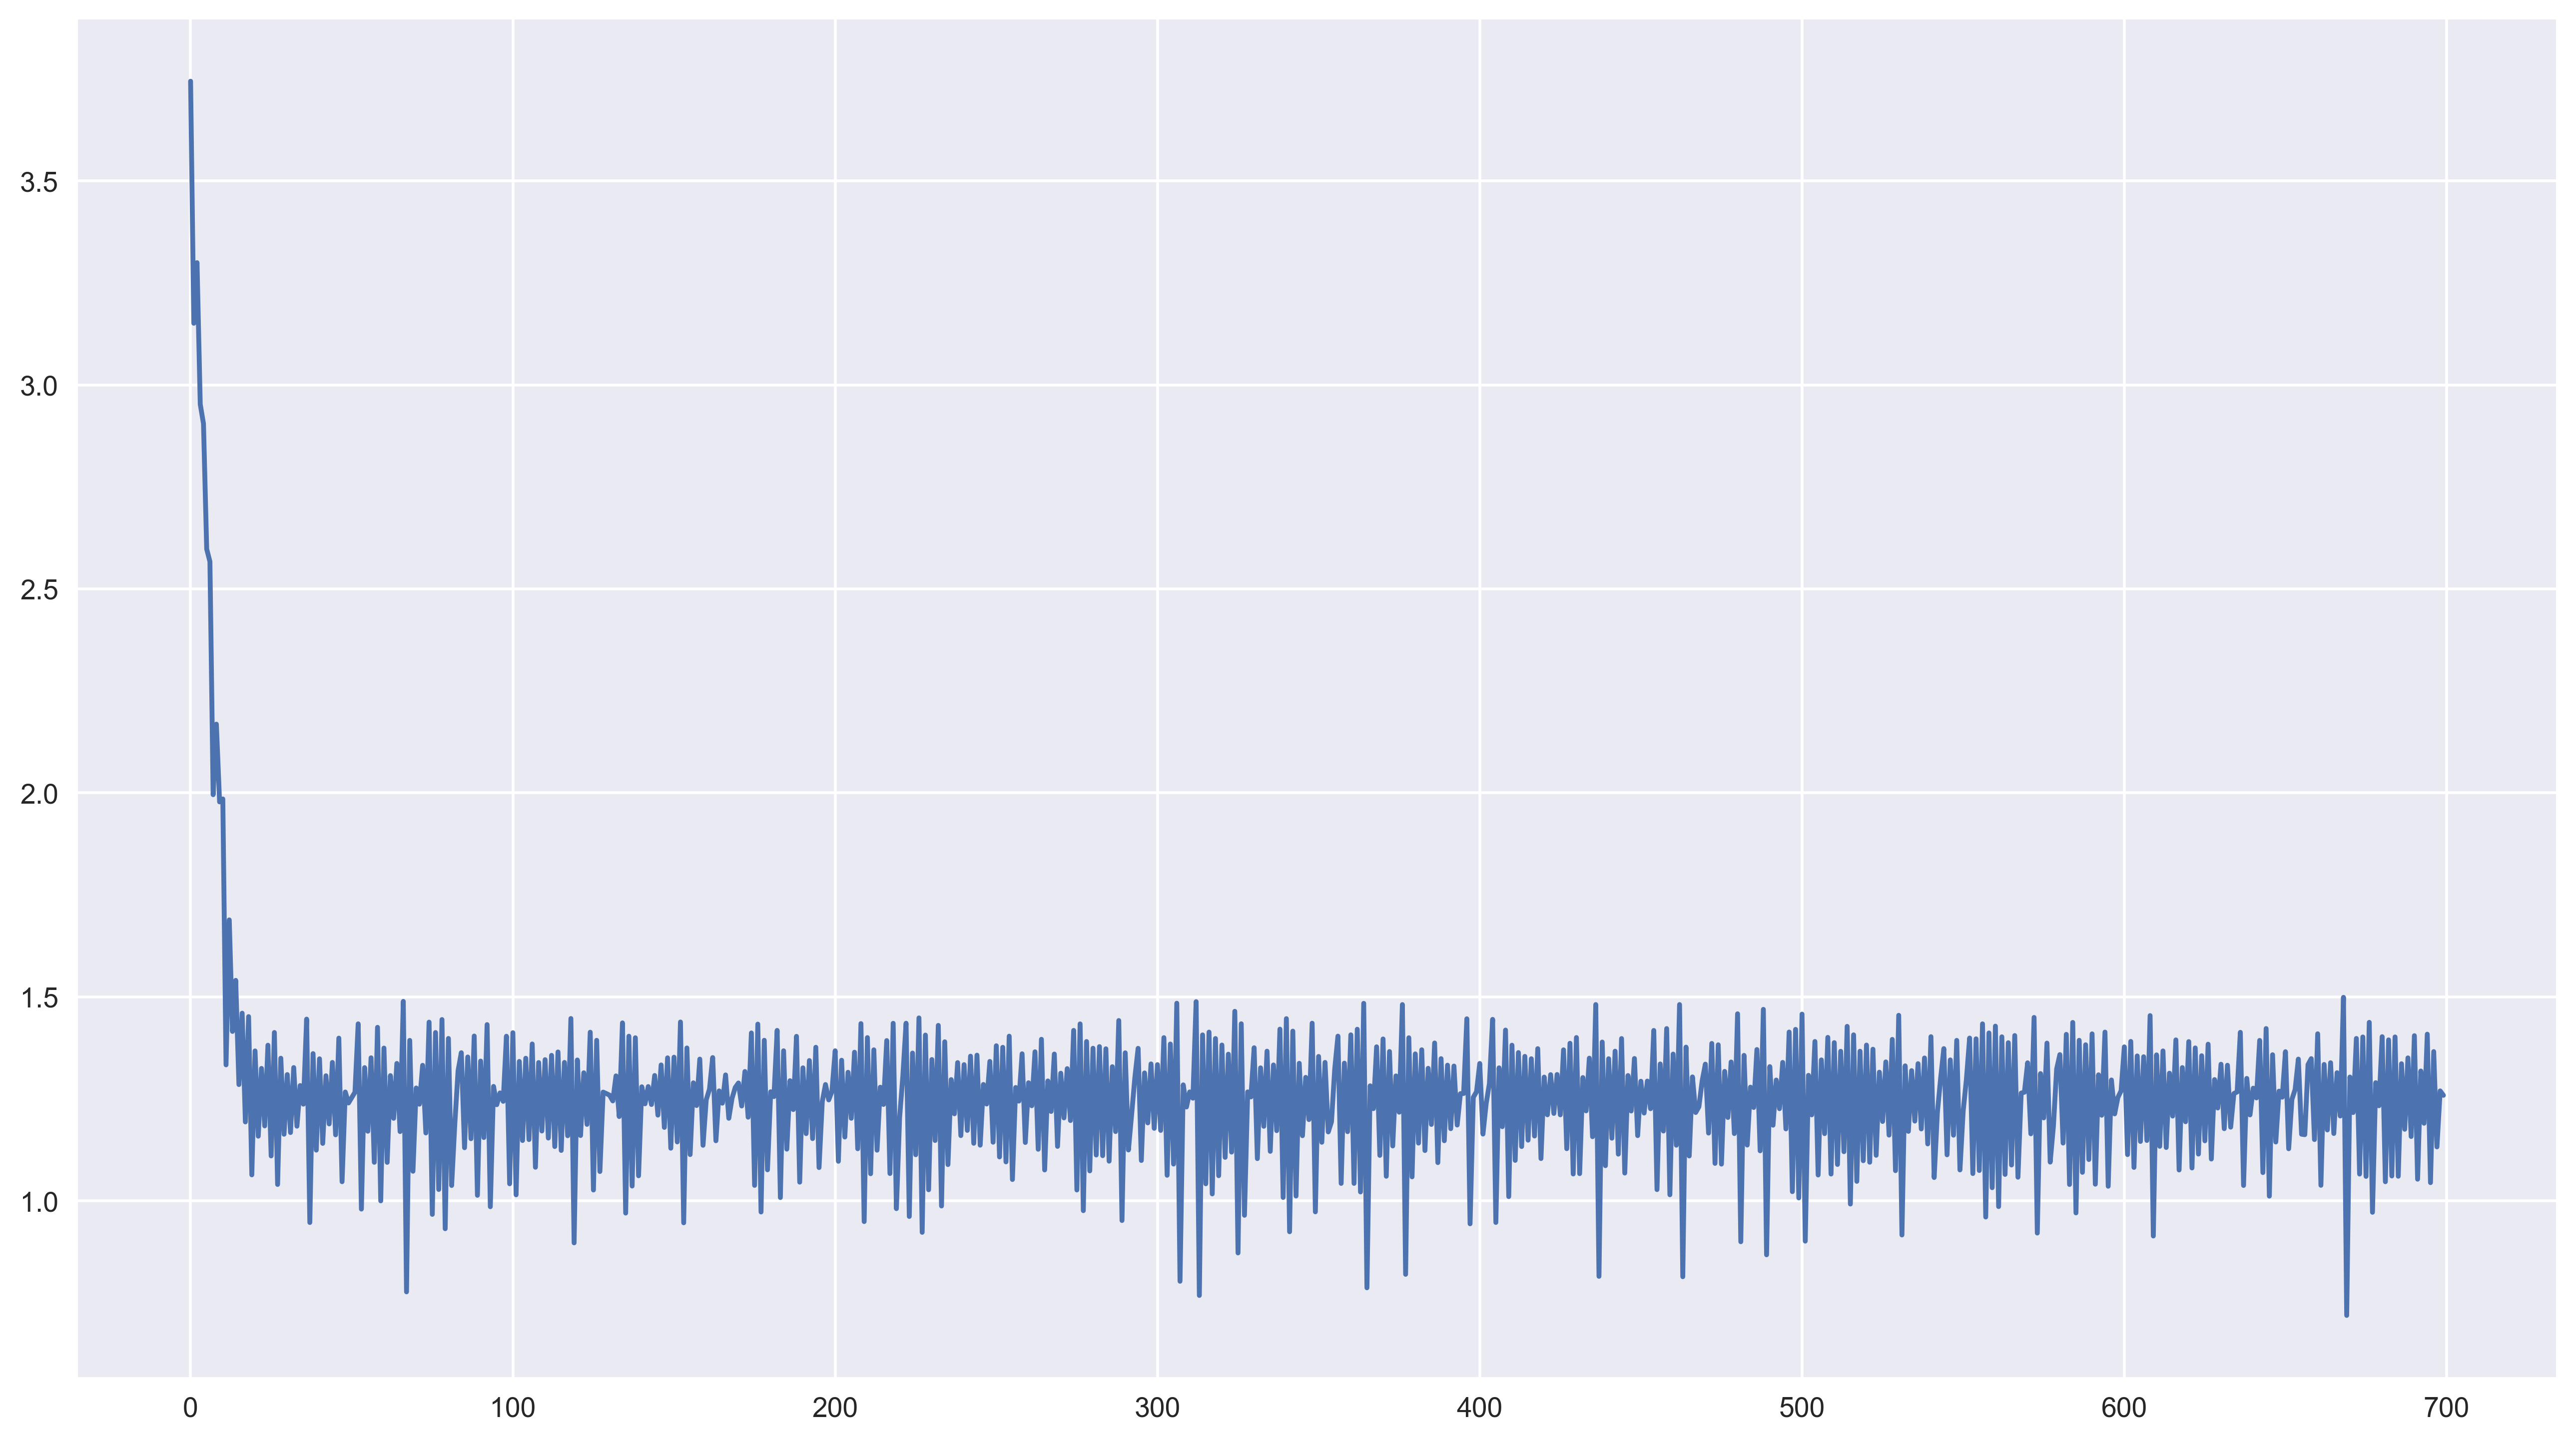

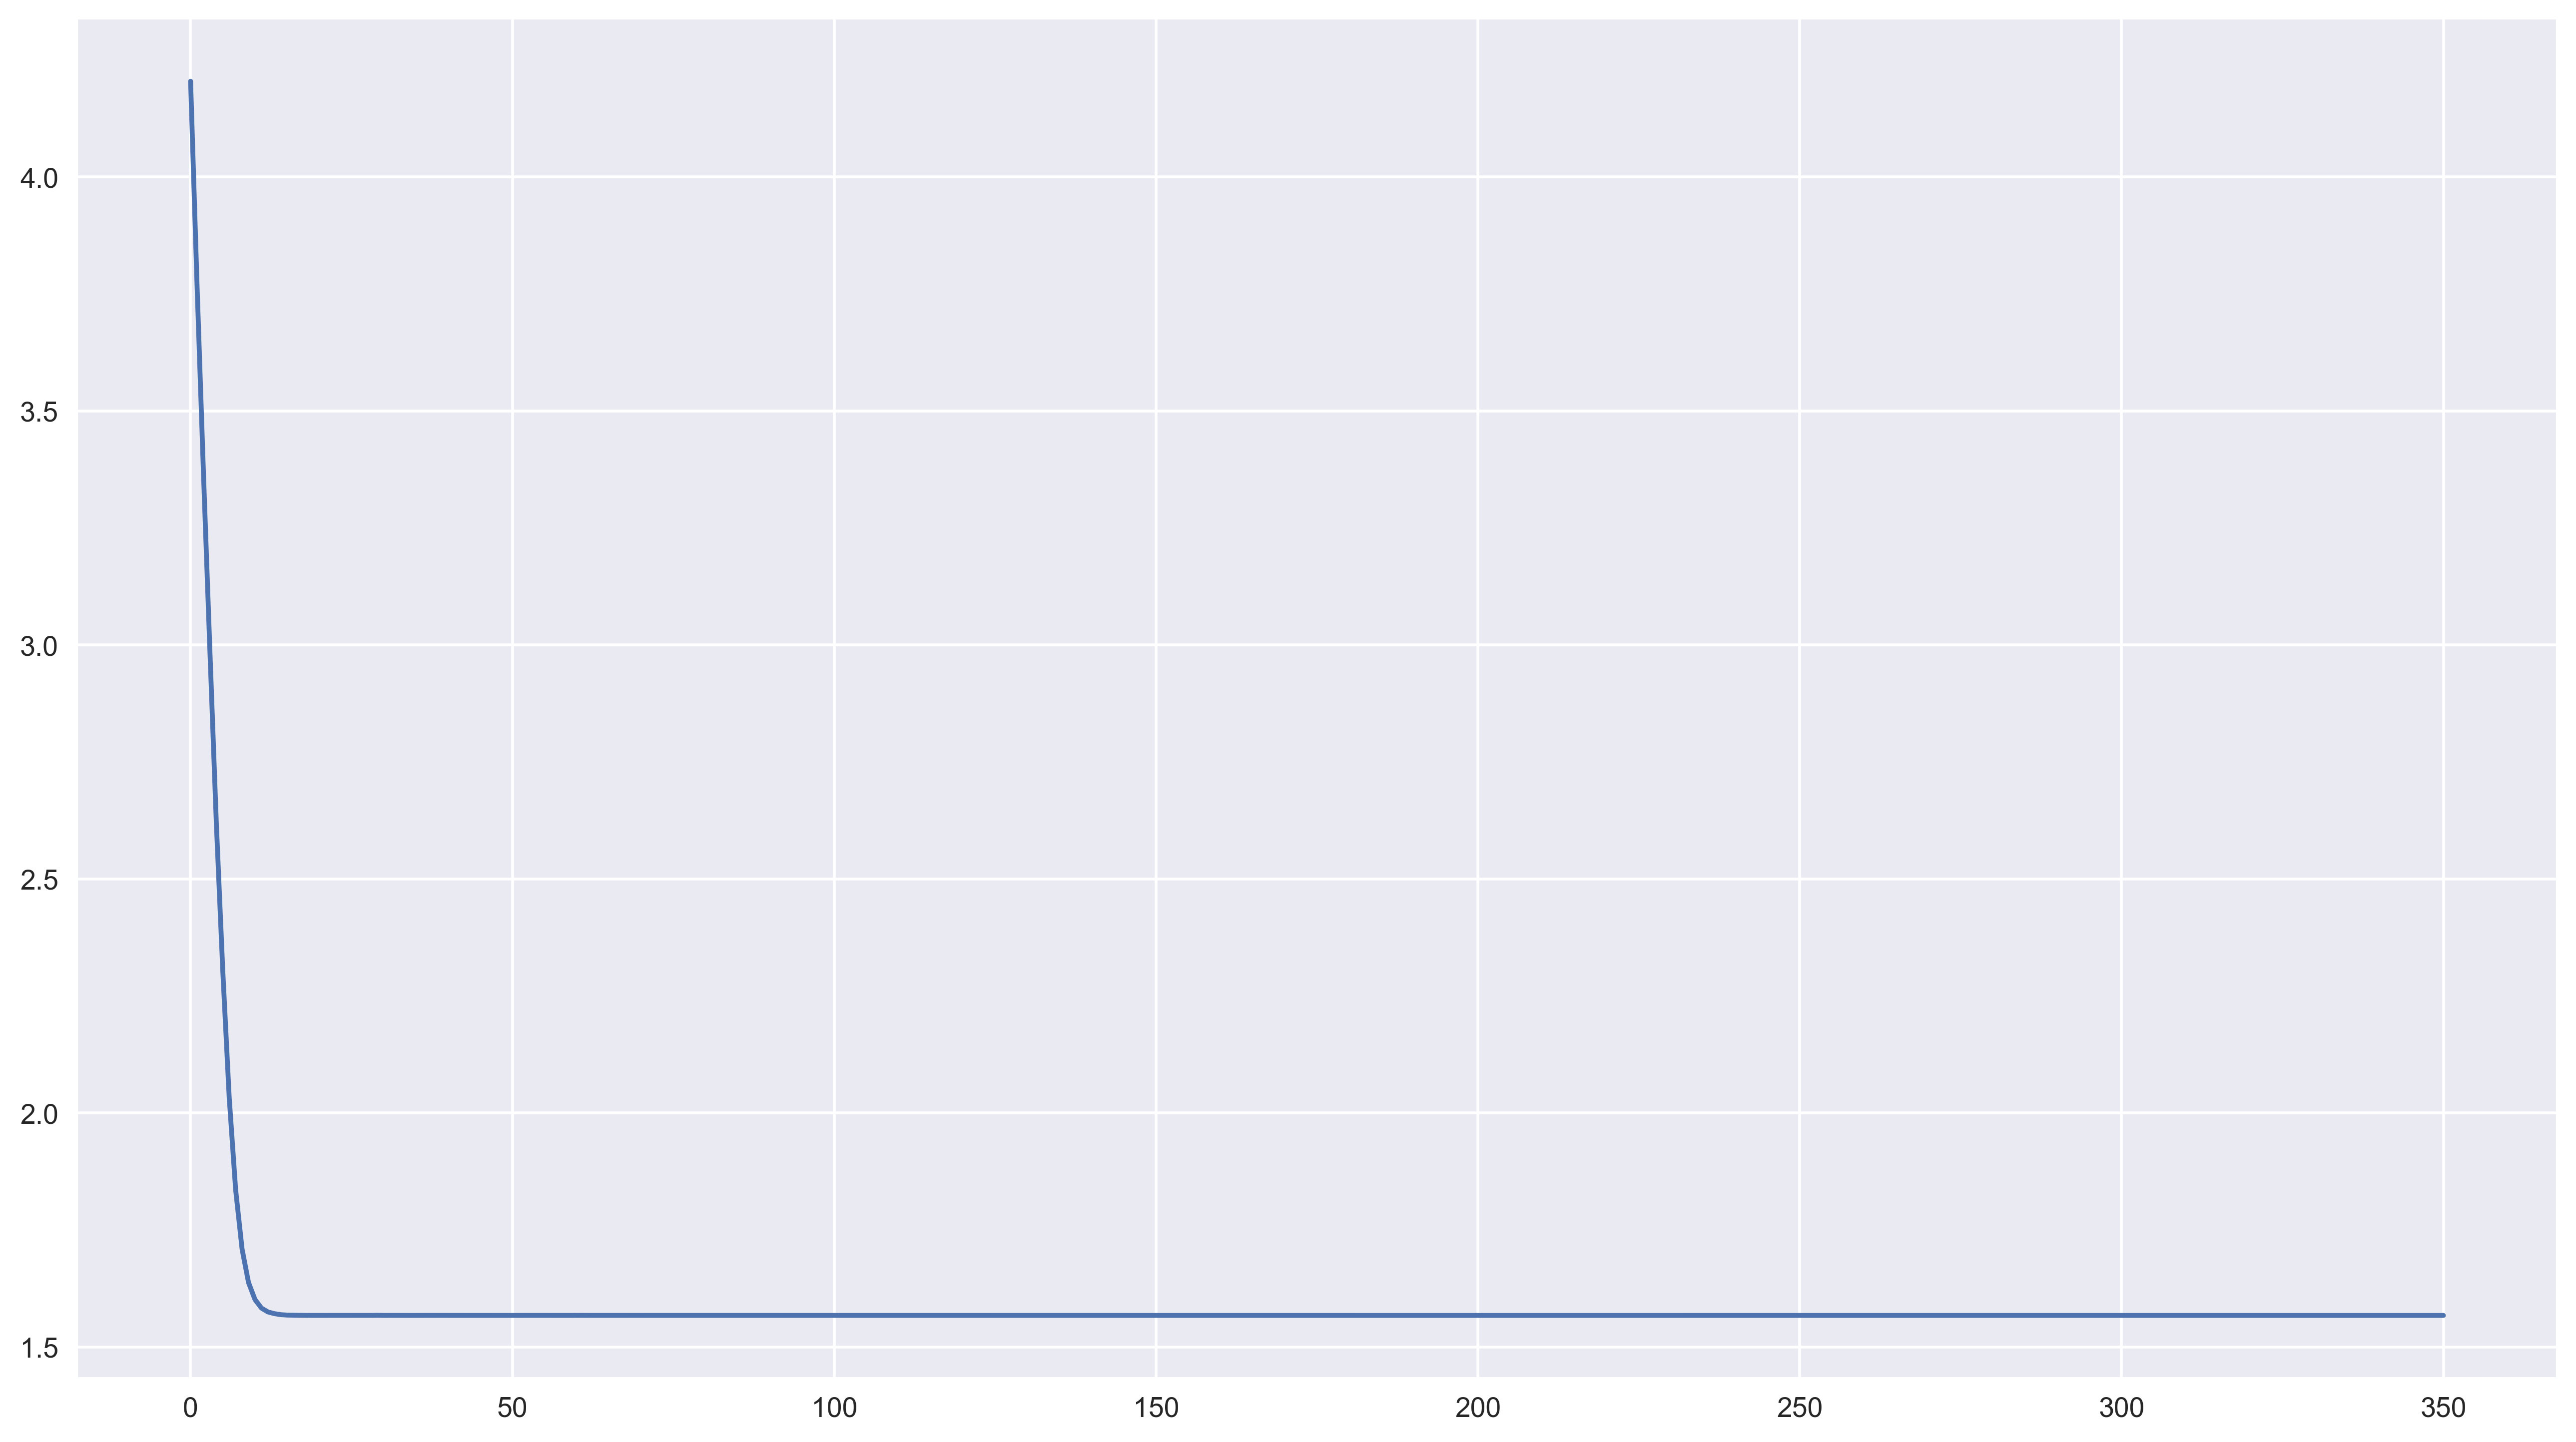

In [464]:
print(theta)
print(optw)
print 'Objective at theta %f and at orginal weights %f' % (objective_function(theta, S), objective_function(optw, S))
print 'Gradient at theta: %.16f' % np.linalg.norm(gradient_fun(theta, S))
plt.plot(np.log10(localerror))
plt.show()
plt.plot(np.log10(error))
plt.show()

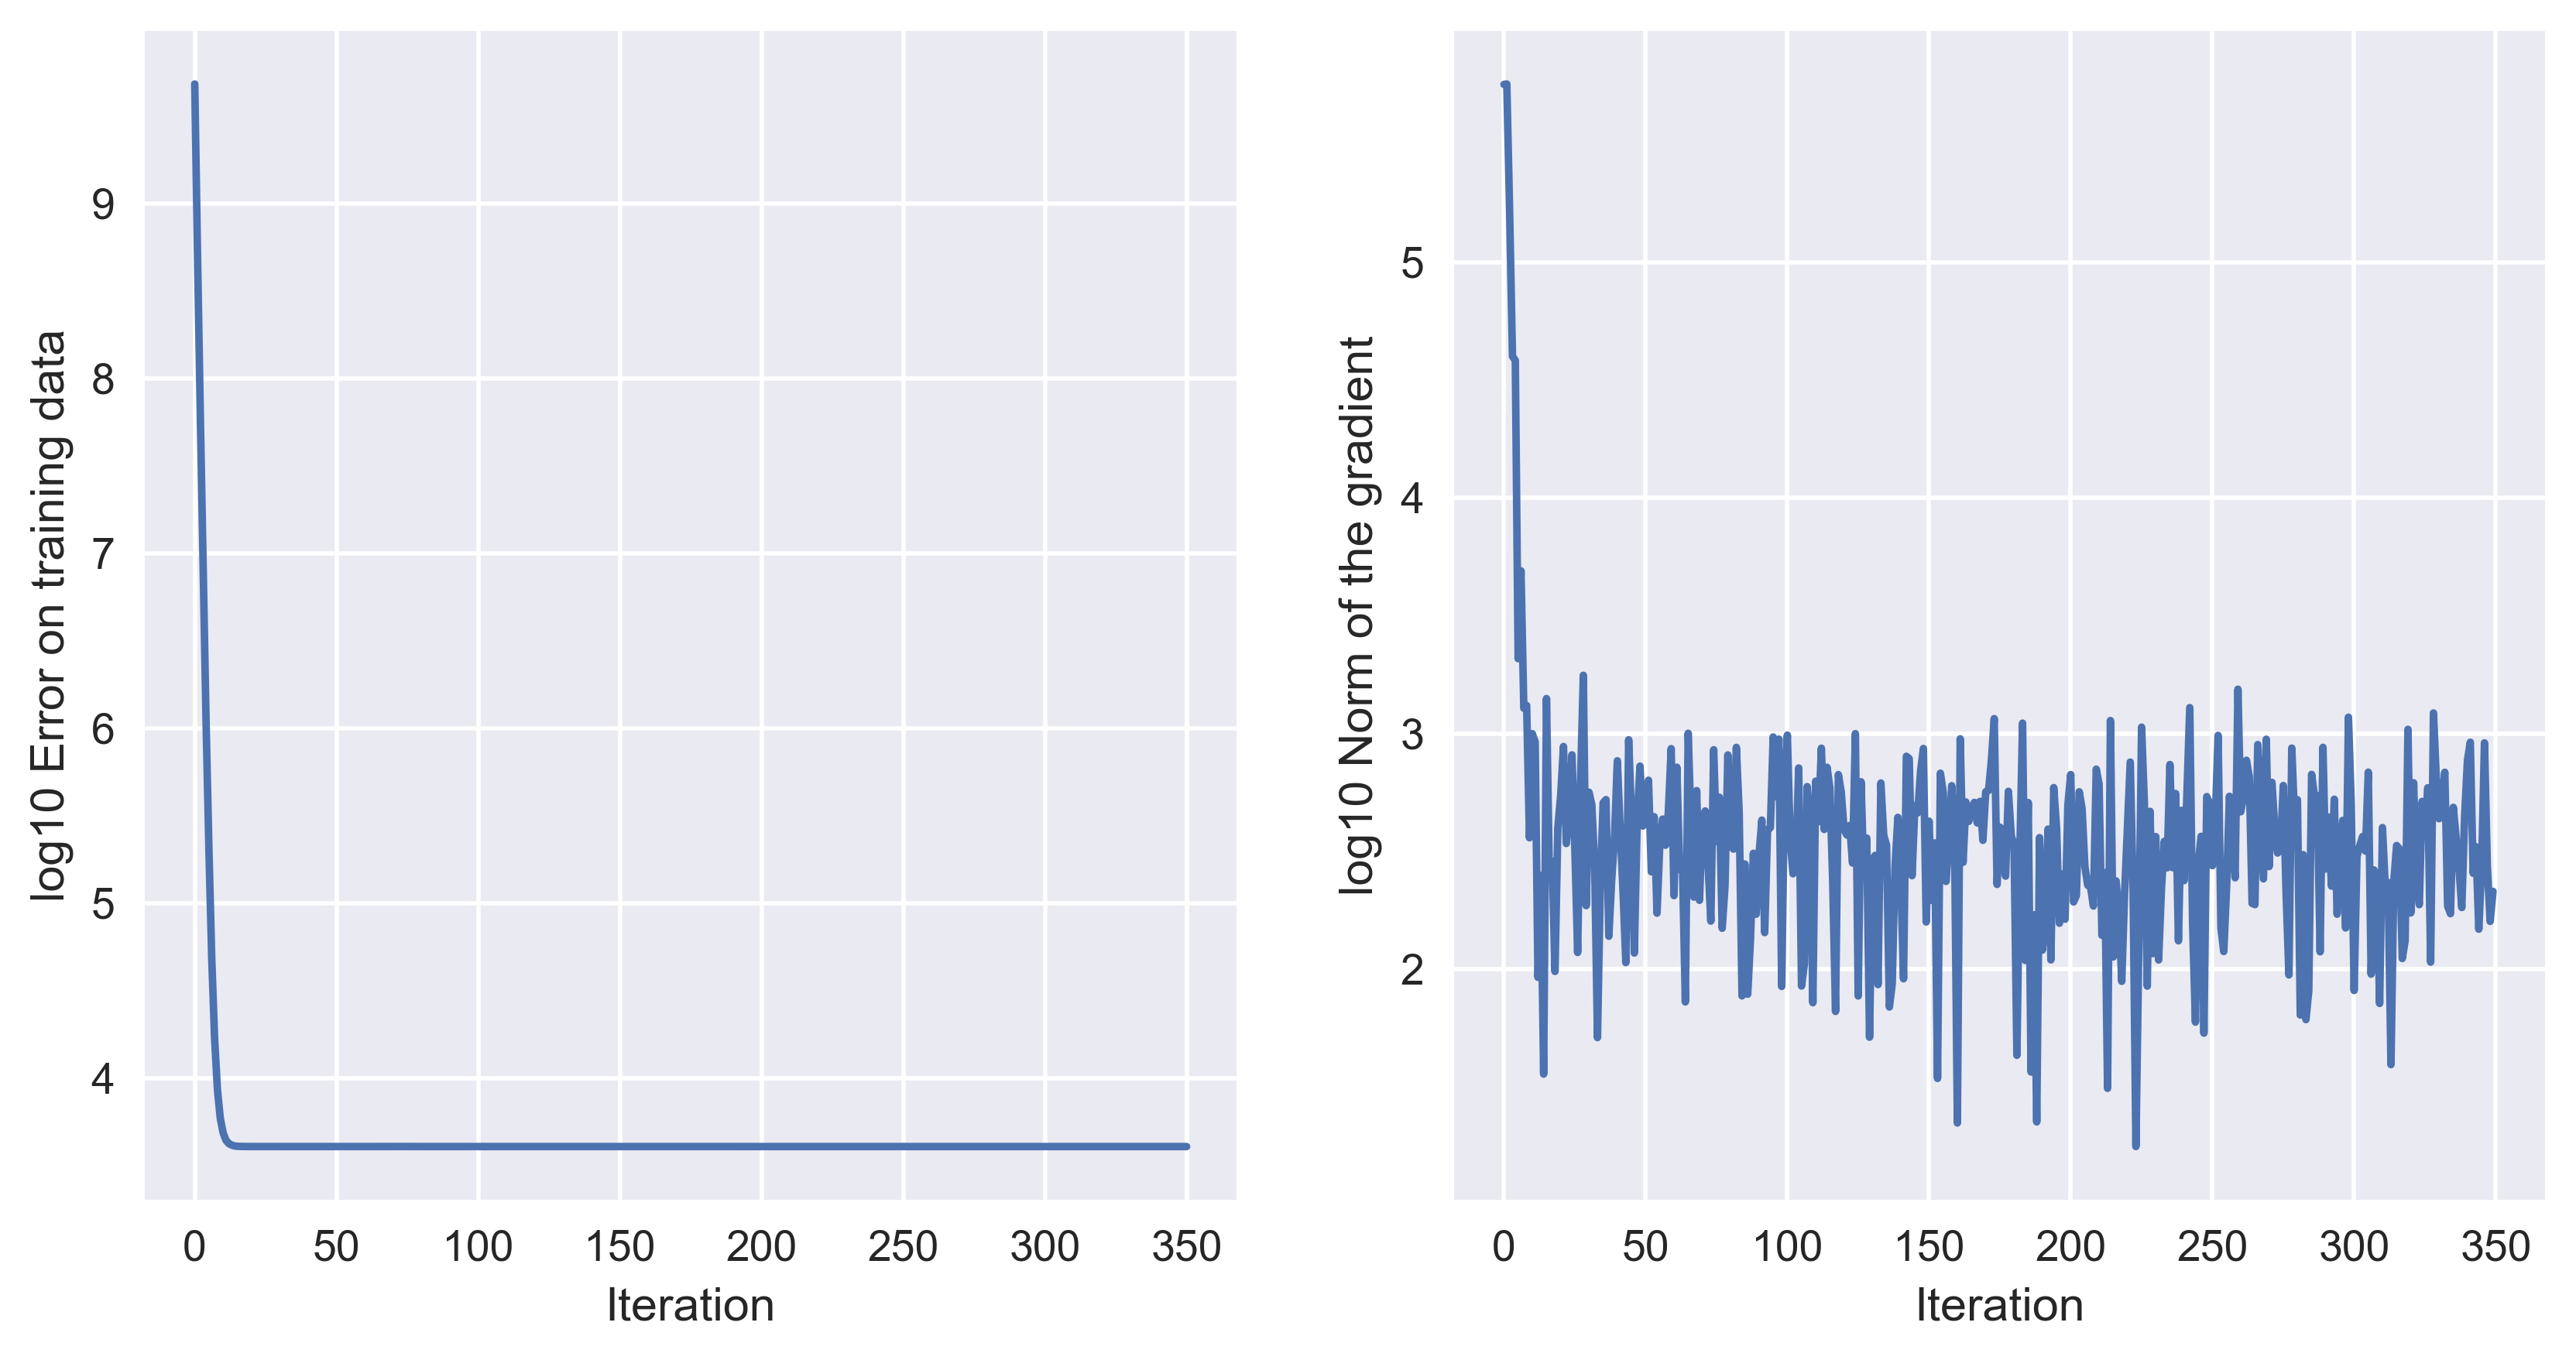

In [465]:
f, axes = plt.subplots(1, 2, sharex=True, sharey=False, figsize=(10, 5))
axes[0].plot(np.log(error))
axes[0].set_ylabel('log10 Error on training data')
axes[0].set_xlabel('Iteration')
axes[1].plot(np.log(gradientNorm))
axes[1].set_ylabel('log10 Norm of the gradient')
axes[1].set_xlabel('Iteration')
plt.show()

# Advances in Gradient Descent

## Momentum update

In [468]:
theta = rnd.normal(size = 5)*rnd.randint(-50, 50, size = 5)# + rnd.normal(size = 5)*50
error = [objective_function(theta, S)]
gradientNorm = list()
gradient_fun = objective_function_gradient
learningRate = 0.01
gamma = 0.1
maxIter = 1000

t = time.time()
condition = True
niter = 0
gradupdate = 0
while condition:
    # Batch gradient computes gradient based on the whole data set
    gradient = gradient_fun(theta, S)
    gradupdate = gradupdate*gamma + learningRate*gradient
    theta -= gradupdate#theta*gamma + learningRate*gradient
    niter += 1
    error.append(objective_function(theta, S))
    gradientNorm.append(np.linalg.norm(gradient))
    condition = not (np.isclose(0., np.linalg.norm(gradient)) or niter > maxIter)
print 'Computed %d iterations in %s seconds.' % (niter, (time.time() - t))

Computed 24 iterations in 0.153000116348 seconds.


In [469]:
print(theta)
print(optw)
print 'Objective at theta %f and at orginal weights %f' % (objective_function(theta, S), objective_function(optw, S))
print 'Gradient at theta: %.16f' % np.linalg.norm(gradient_fun(theta, S))

[-2.00127602  1.11050317  3.79647762  9.05509407  6.93406601]
[-2.  1.  4.  9.  7.]
Objective at theta 36.919757 and at orginal weights 39.473233
Gradient at theta: 0.0000000026031748


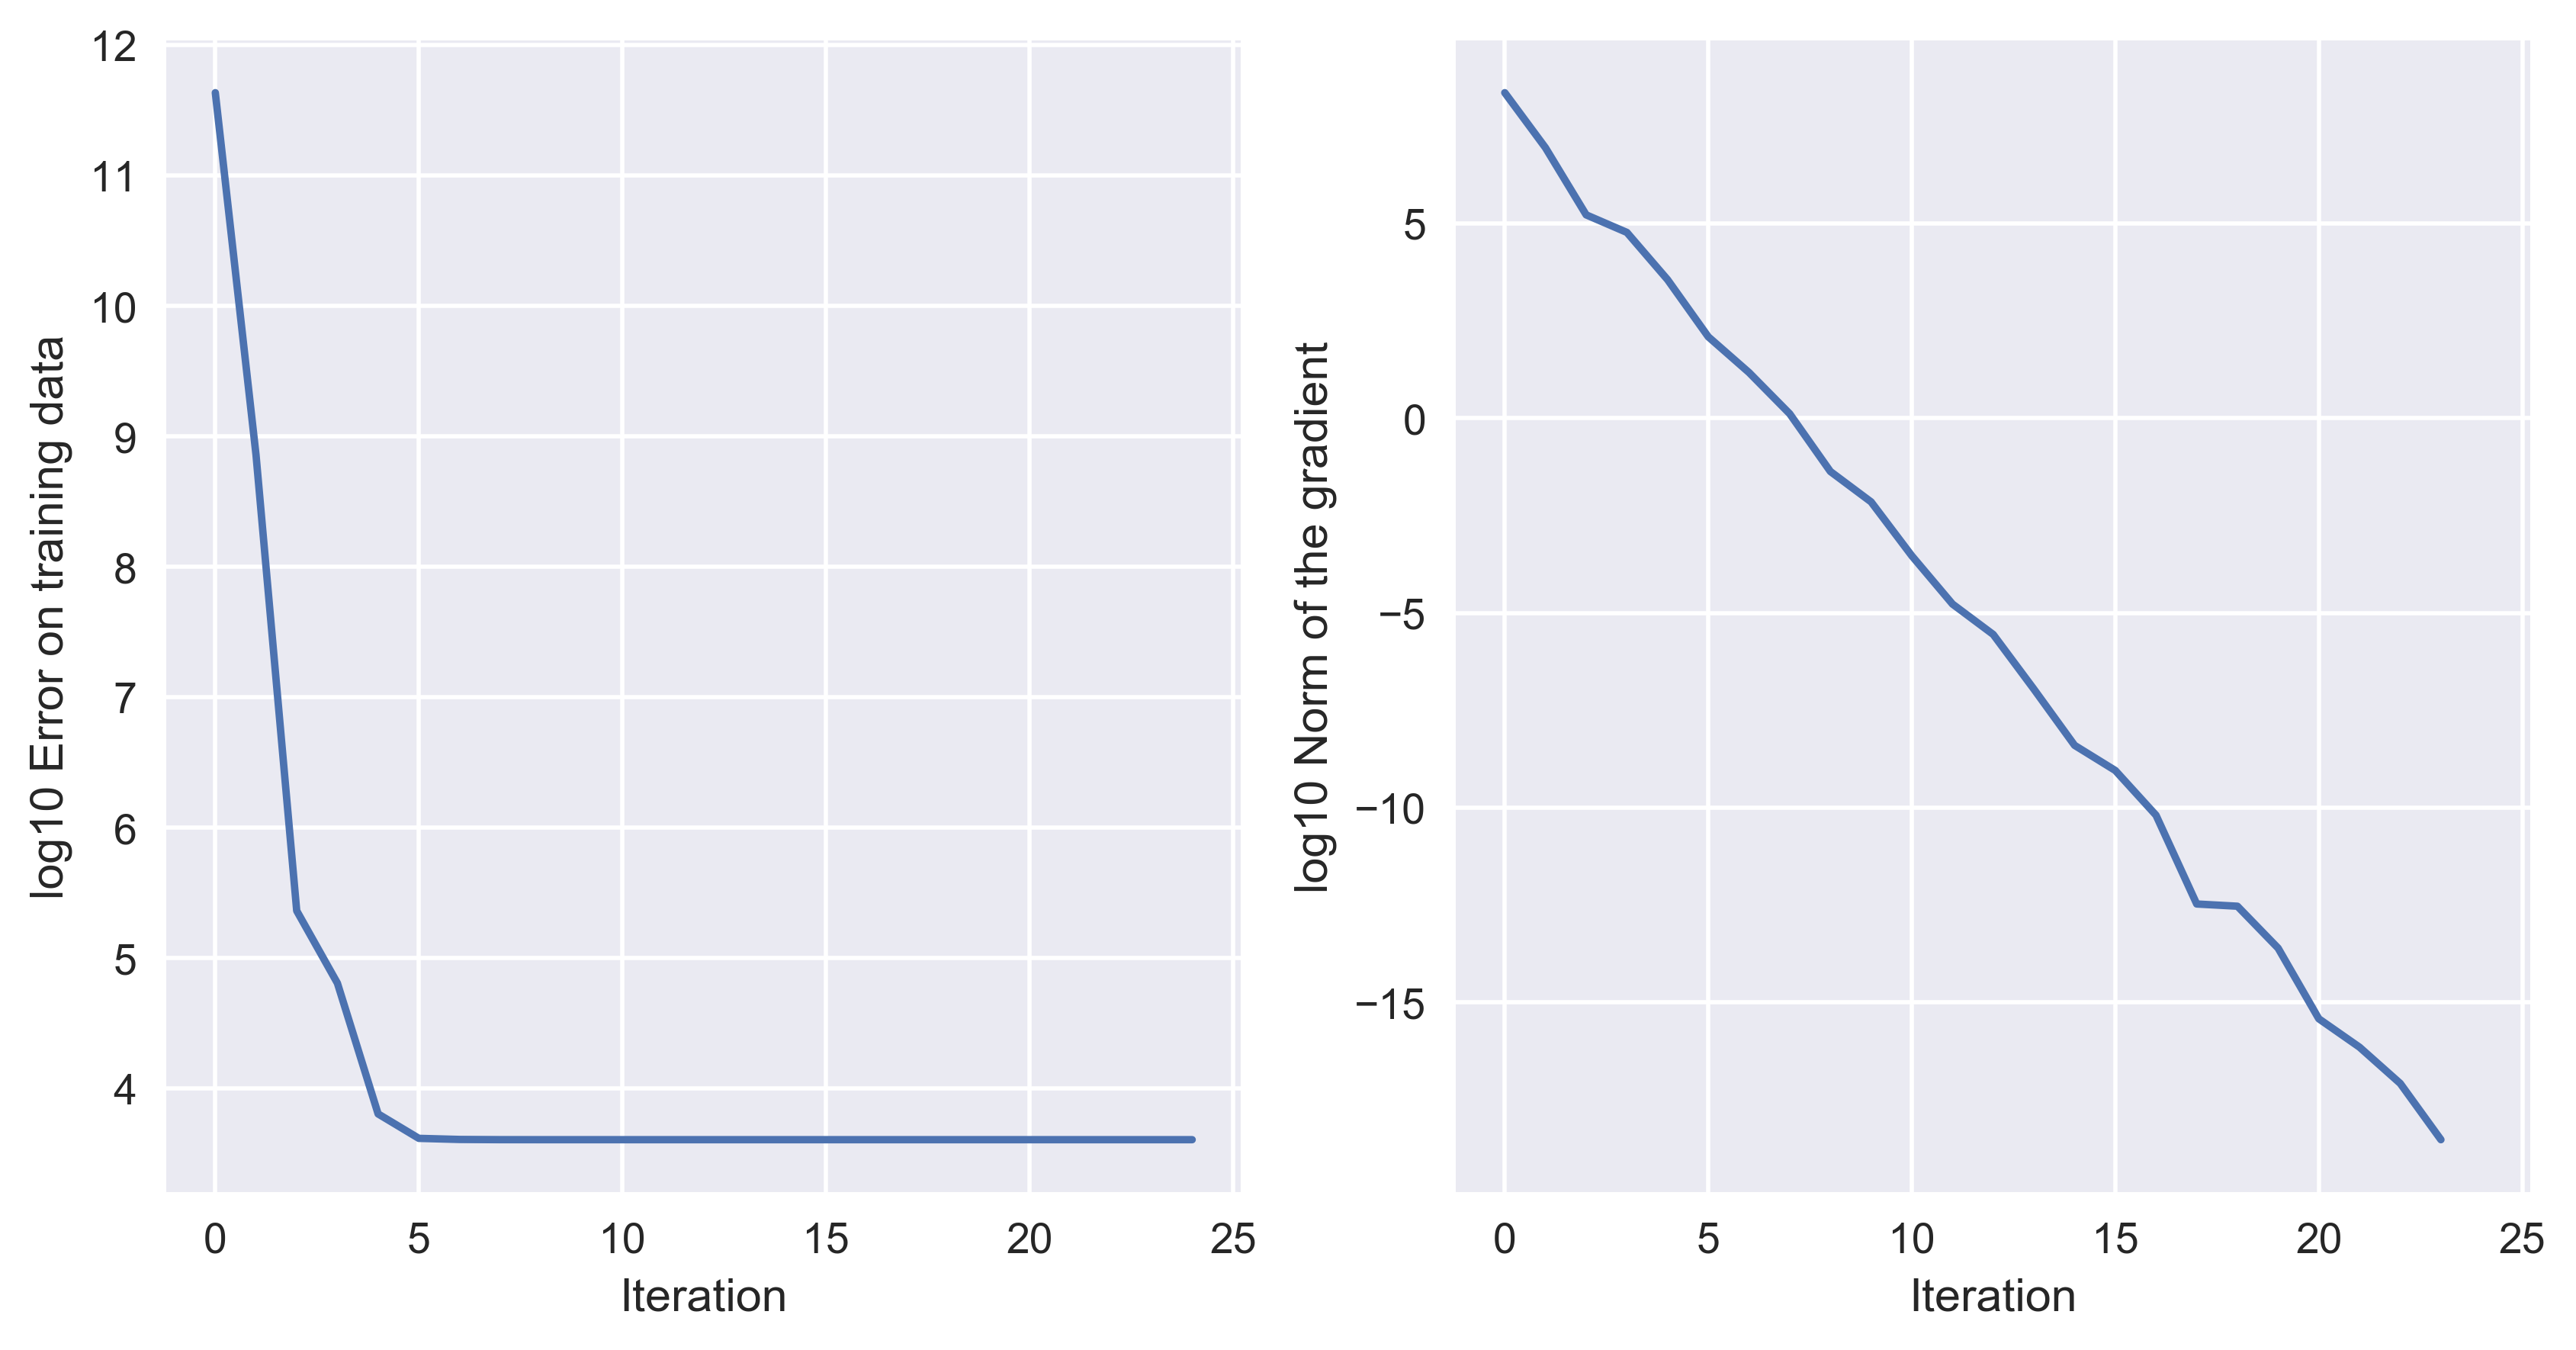

In [470]:
f, axes = plt.subplots(1, 2, sharex=True, sharey=False, figsize=(10, 5))
axes[0].plot(np.log(error))
axes[0].set_ylabel('log10 Error on training data')
axes[0].set_xlabel('Iteration')
axes[1].plot(np.log(gradientNorm))
axes[1].set_ylabel('log10 Norm of the gradient')
axes[1].set_xlabel('Iteration')
plt.show()

### Mini Batch Variant

Computed in 2.74800014496 seconds
[ -5.7430676  -10.15399269  -2.90419939  -0.97552165   4.91711307]
[ -6. -10.  -3.  -1.   5.]
Objective at theta 31.366729 and at orginal weights 35.207165
Gradient at theta: 2.4169613864230870


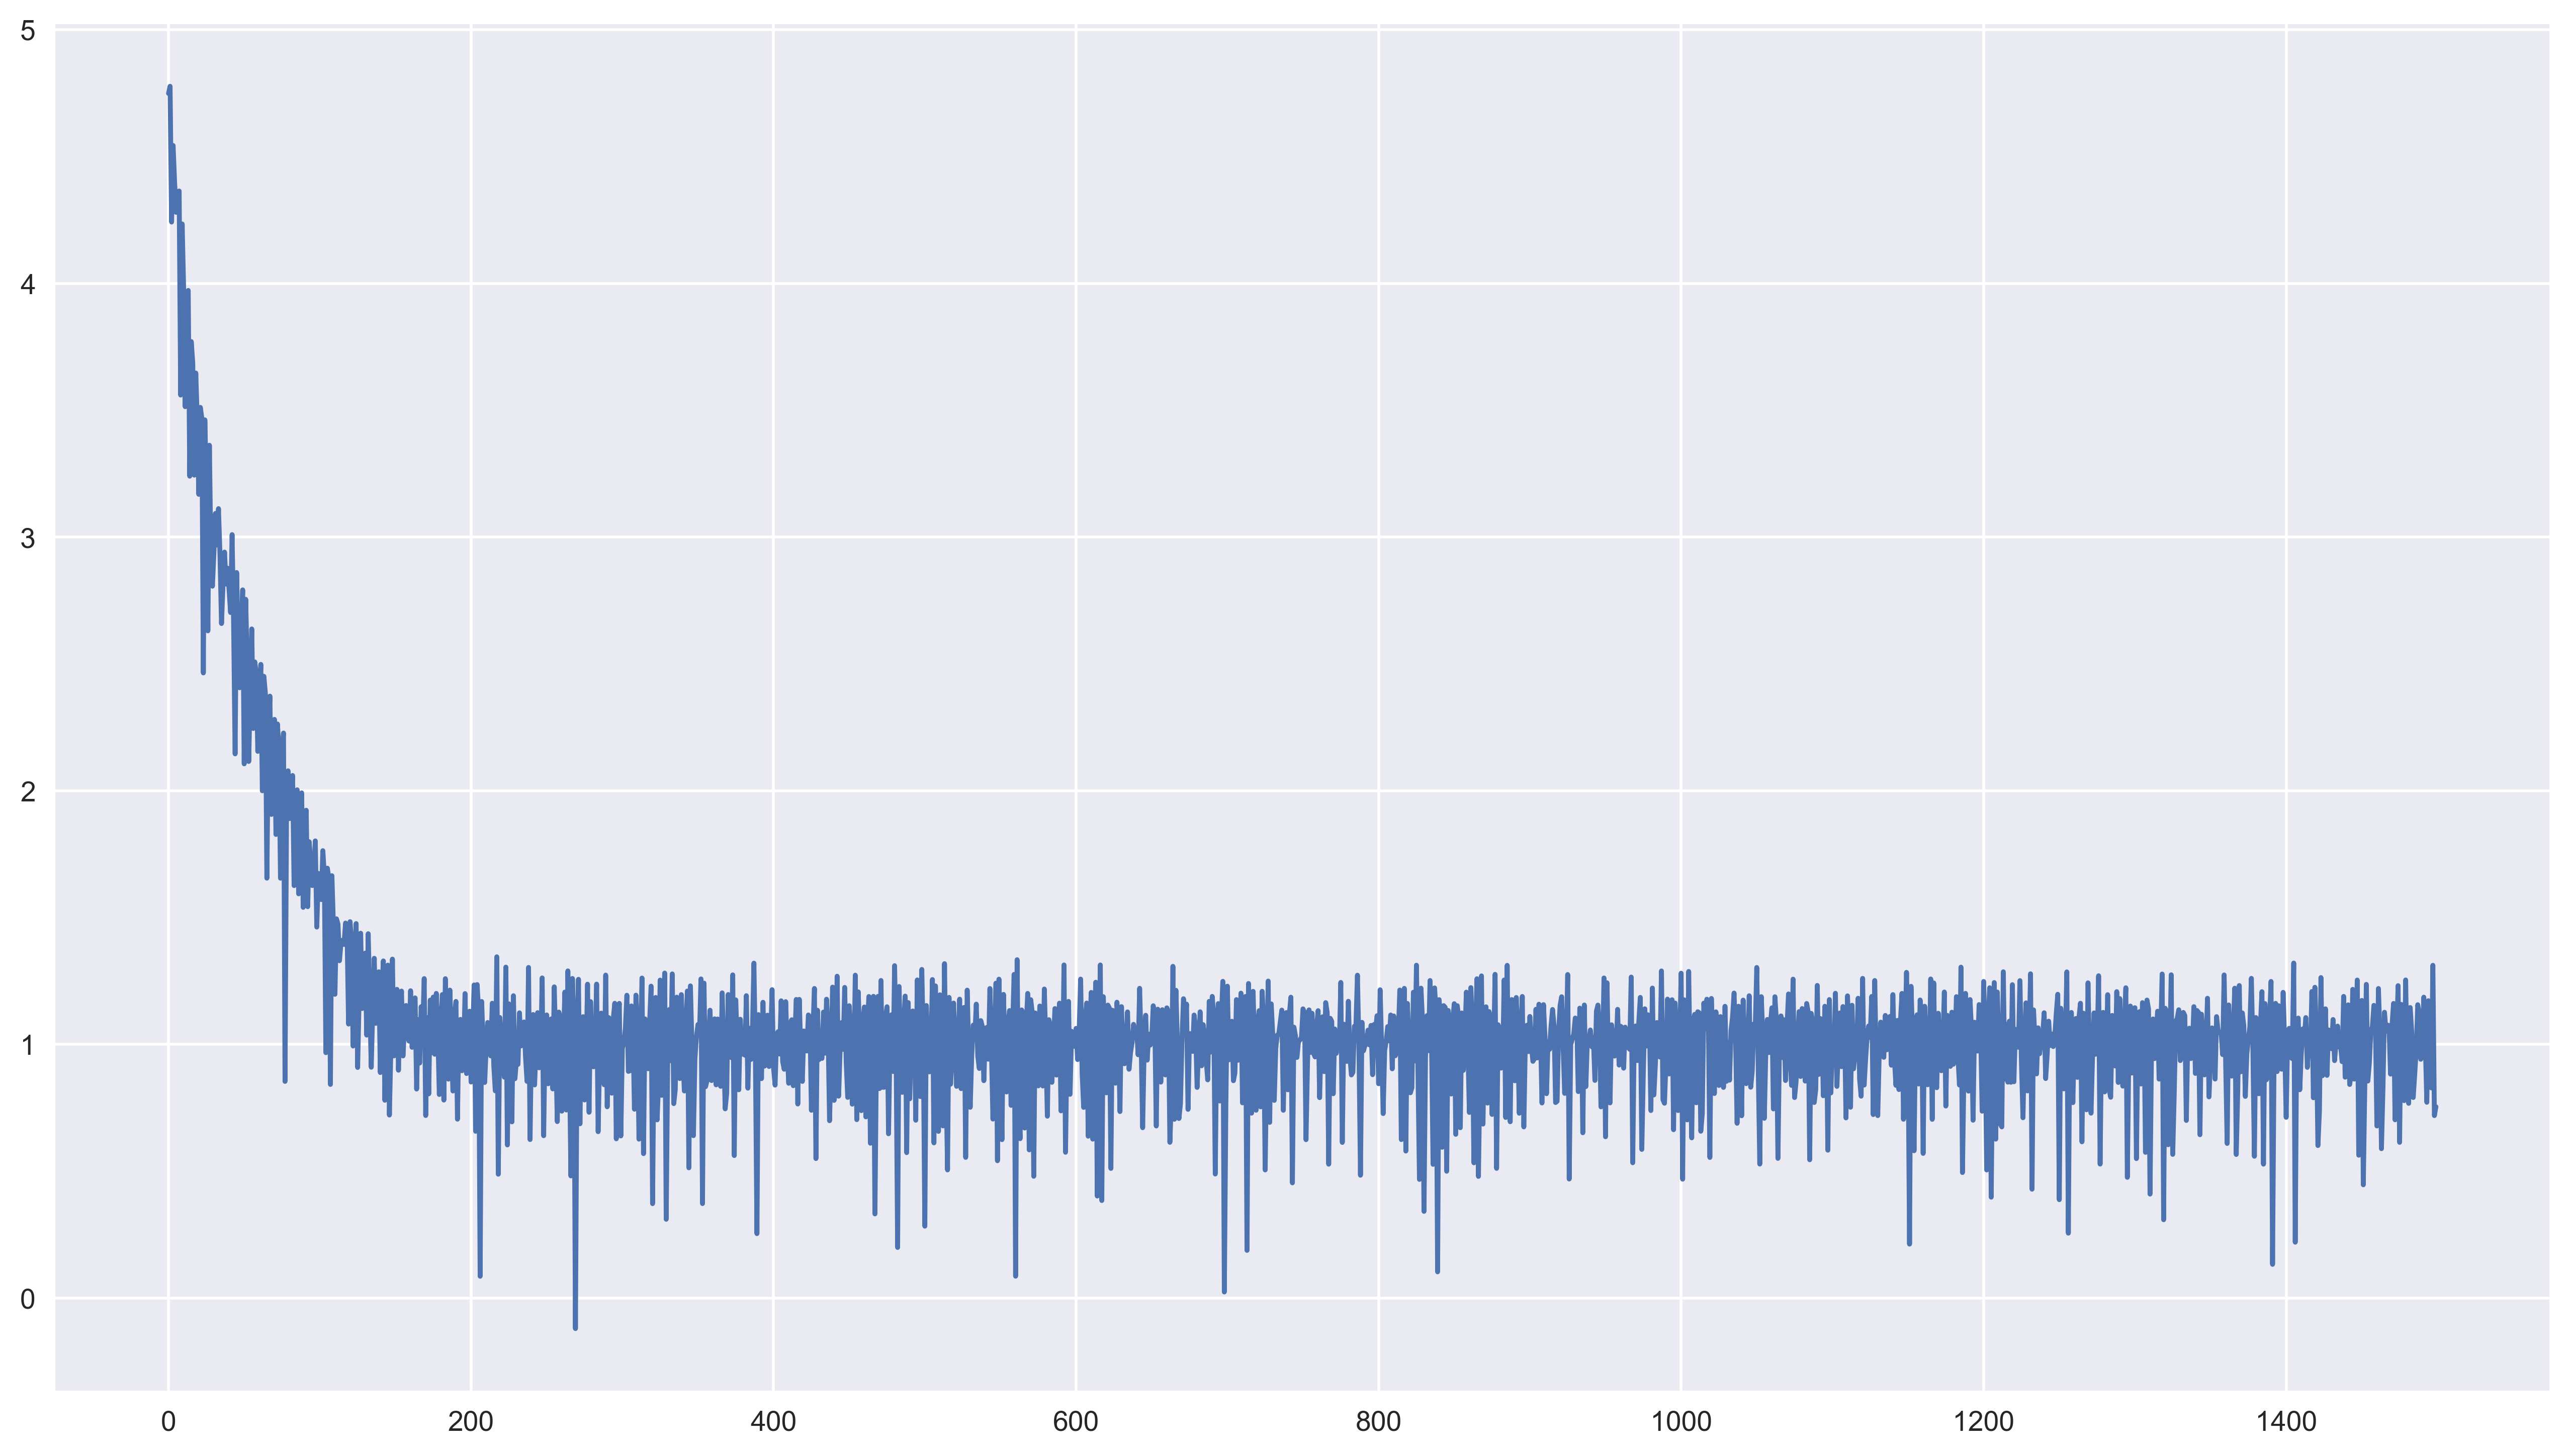

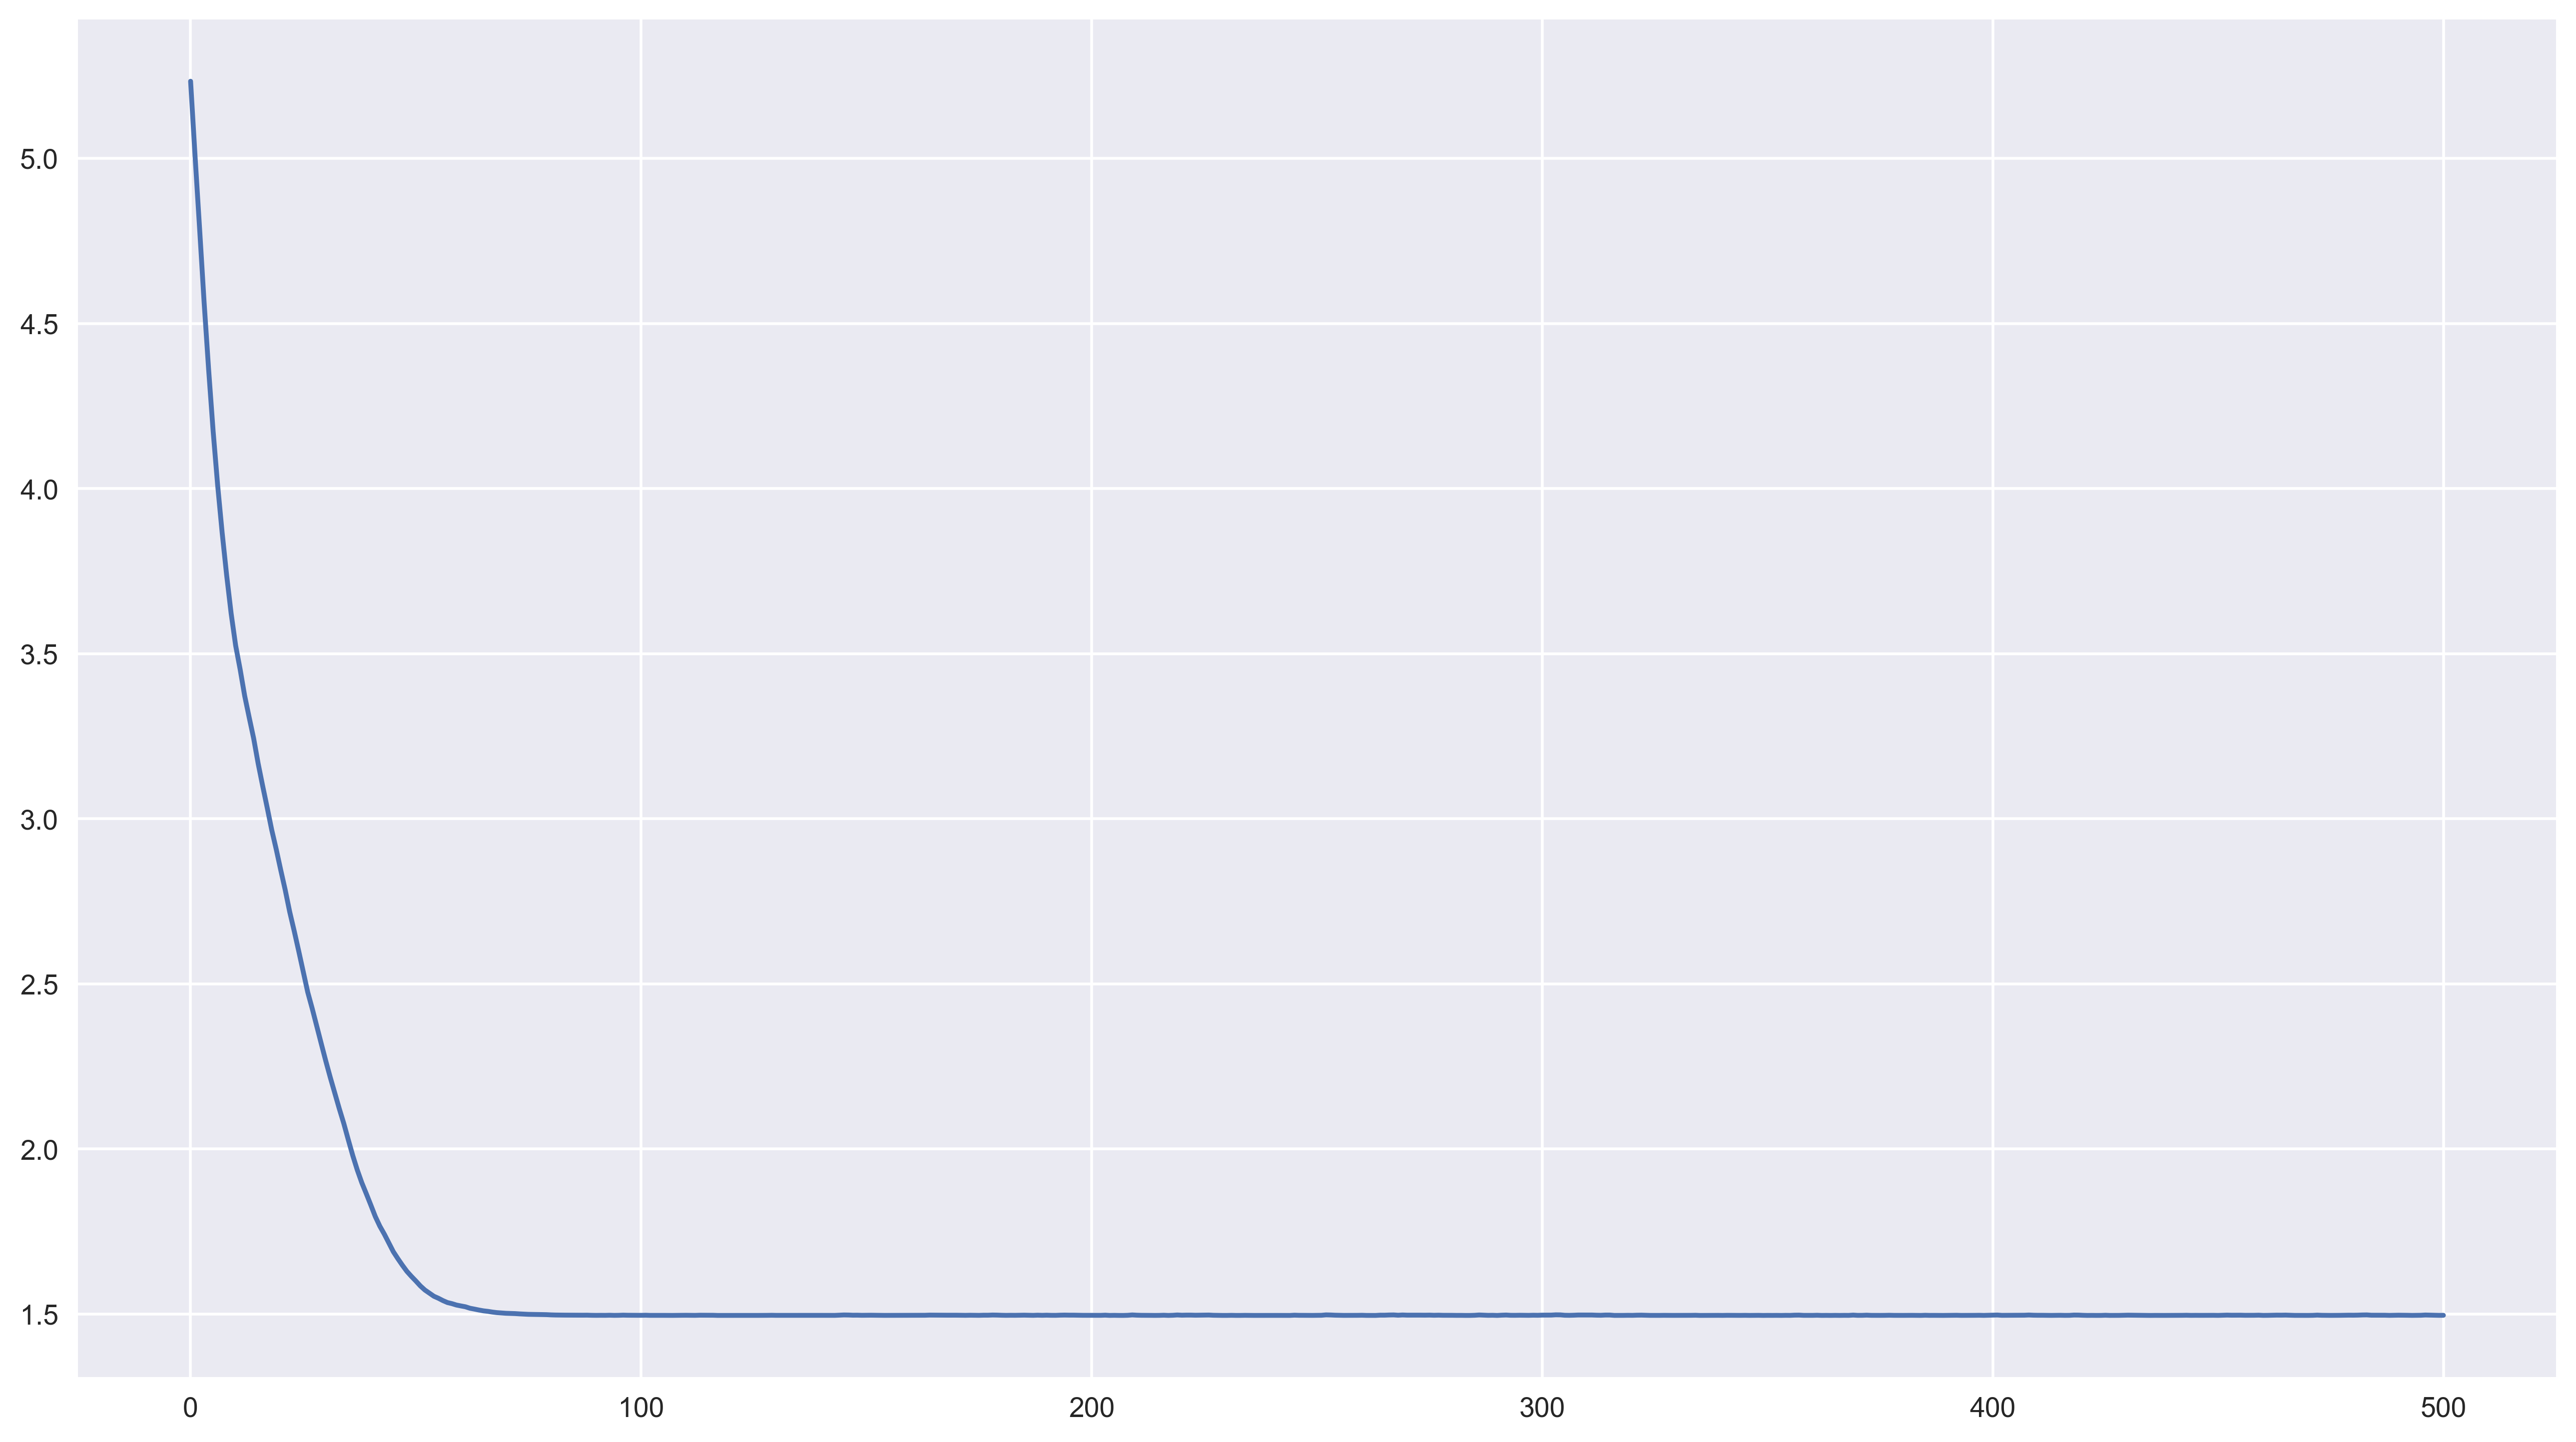

In [369]:
theta = rnd.normal(size = 5)*rnd.randint(-50, 50, size = 5)# + rnd.normal(size = 5)*50
localError = []
globalError = [objective_function(theta, S)]
gradient_fun = objective_function_gradient
learningRate = 0.001
gamma = 0.9
batchSize = 20
maxIter = 100

t = time.time()
for epoch in xrange(500):
    rnd.shuffle(S)    
    batches = [S[i:i + batchSize] for i in xrange(0, len(S), batchSize)]
    gradupdate = 0
    for _S in batches:
        gradient = gradient_fun(theta, _S)
        gradupdate = gradupdate*gamma + learningRate*gradient
        theta -= gradupdate
        localError.append(objective_function(theta, _S))
    globalError.append(objective_function(theta, S))

print 'Computed in %s seconds' % (time.time() - t)
print(theta)
print(optw)
print 'Objective at theta %f and at orginal weights %f' % (objective_function(theta, S), objective_function(optw, S))
print 'Gradient at theta: %.16f' % np.linalg.norm(gradient_fun(theta, S))
plt.plot(np.log10(localError))
plt.show()
plt.plot(np.log10(globalError))
plt.show()

## Nesterov Accelerated Momentum

In [370]:
theta = rnd.normal(size = 5)*rnd.randint(-50, 50, size = 5)# + rnd.normal(size = 5)*50
error = [objective_function(theta, S)]
gradient_fun = objective_function_gradient
learningRate = 0.001
gamma = 0.9
maxIter = 1000

t = time.time()
condition = True
niter = 0
previousGradient = 0
while condition:
    # Batch gradient computes gradient based on the whole data set
    gradient = gradient_fun(theta - previousGradient*gamma, S)
    theta -= previousGradient*gamma + learningRate*gradient
    niter += 1
    error.append(objective_function(theta, S))
    condition = not (np.isclose(0., np.linalg.norm(gradient)) or niter > maxIter)
print 'Computed %d iterations in %s seconds.' % (niter, (time.time() - t))

Computed 676 iterations in 3.60799980164 seconds.


[ -5.76093302 -10.14808163  -2.89947655  -0.97801981   4.9277796 ]
[ -6. -10.  -3.  -1.   5.]
Objective at theta 31.341365 and at orginal weights 35.207165
Gradient at theta: 0.0000000095895286


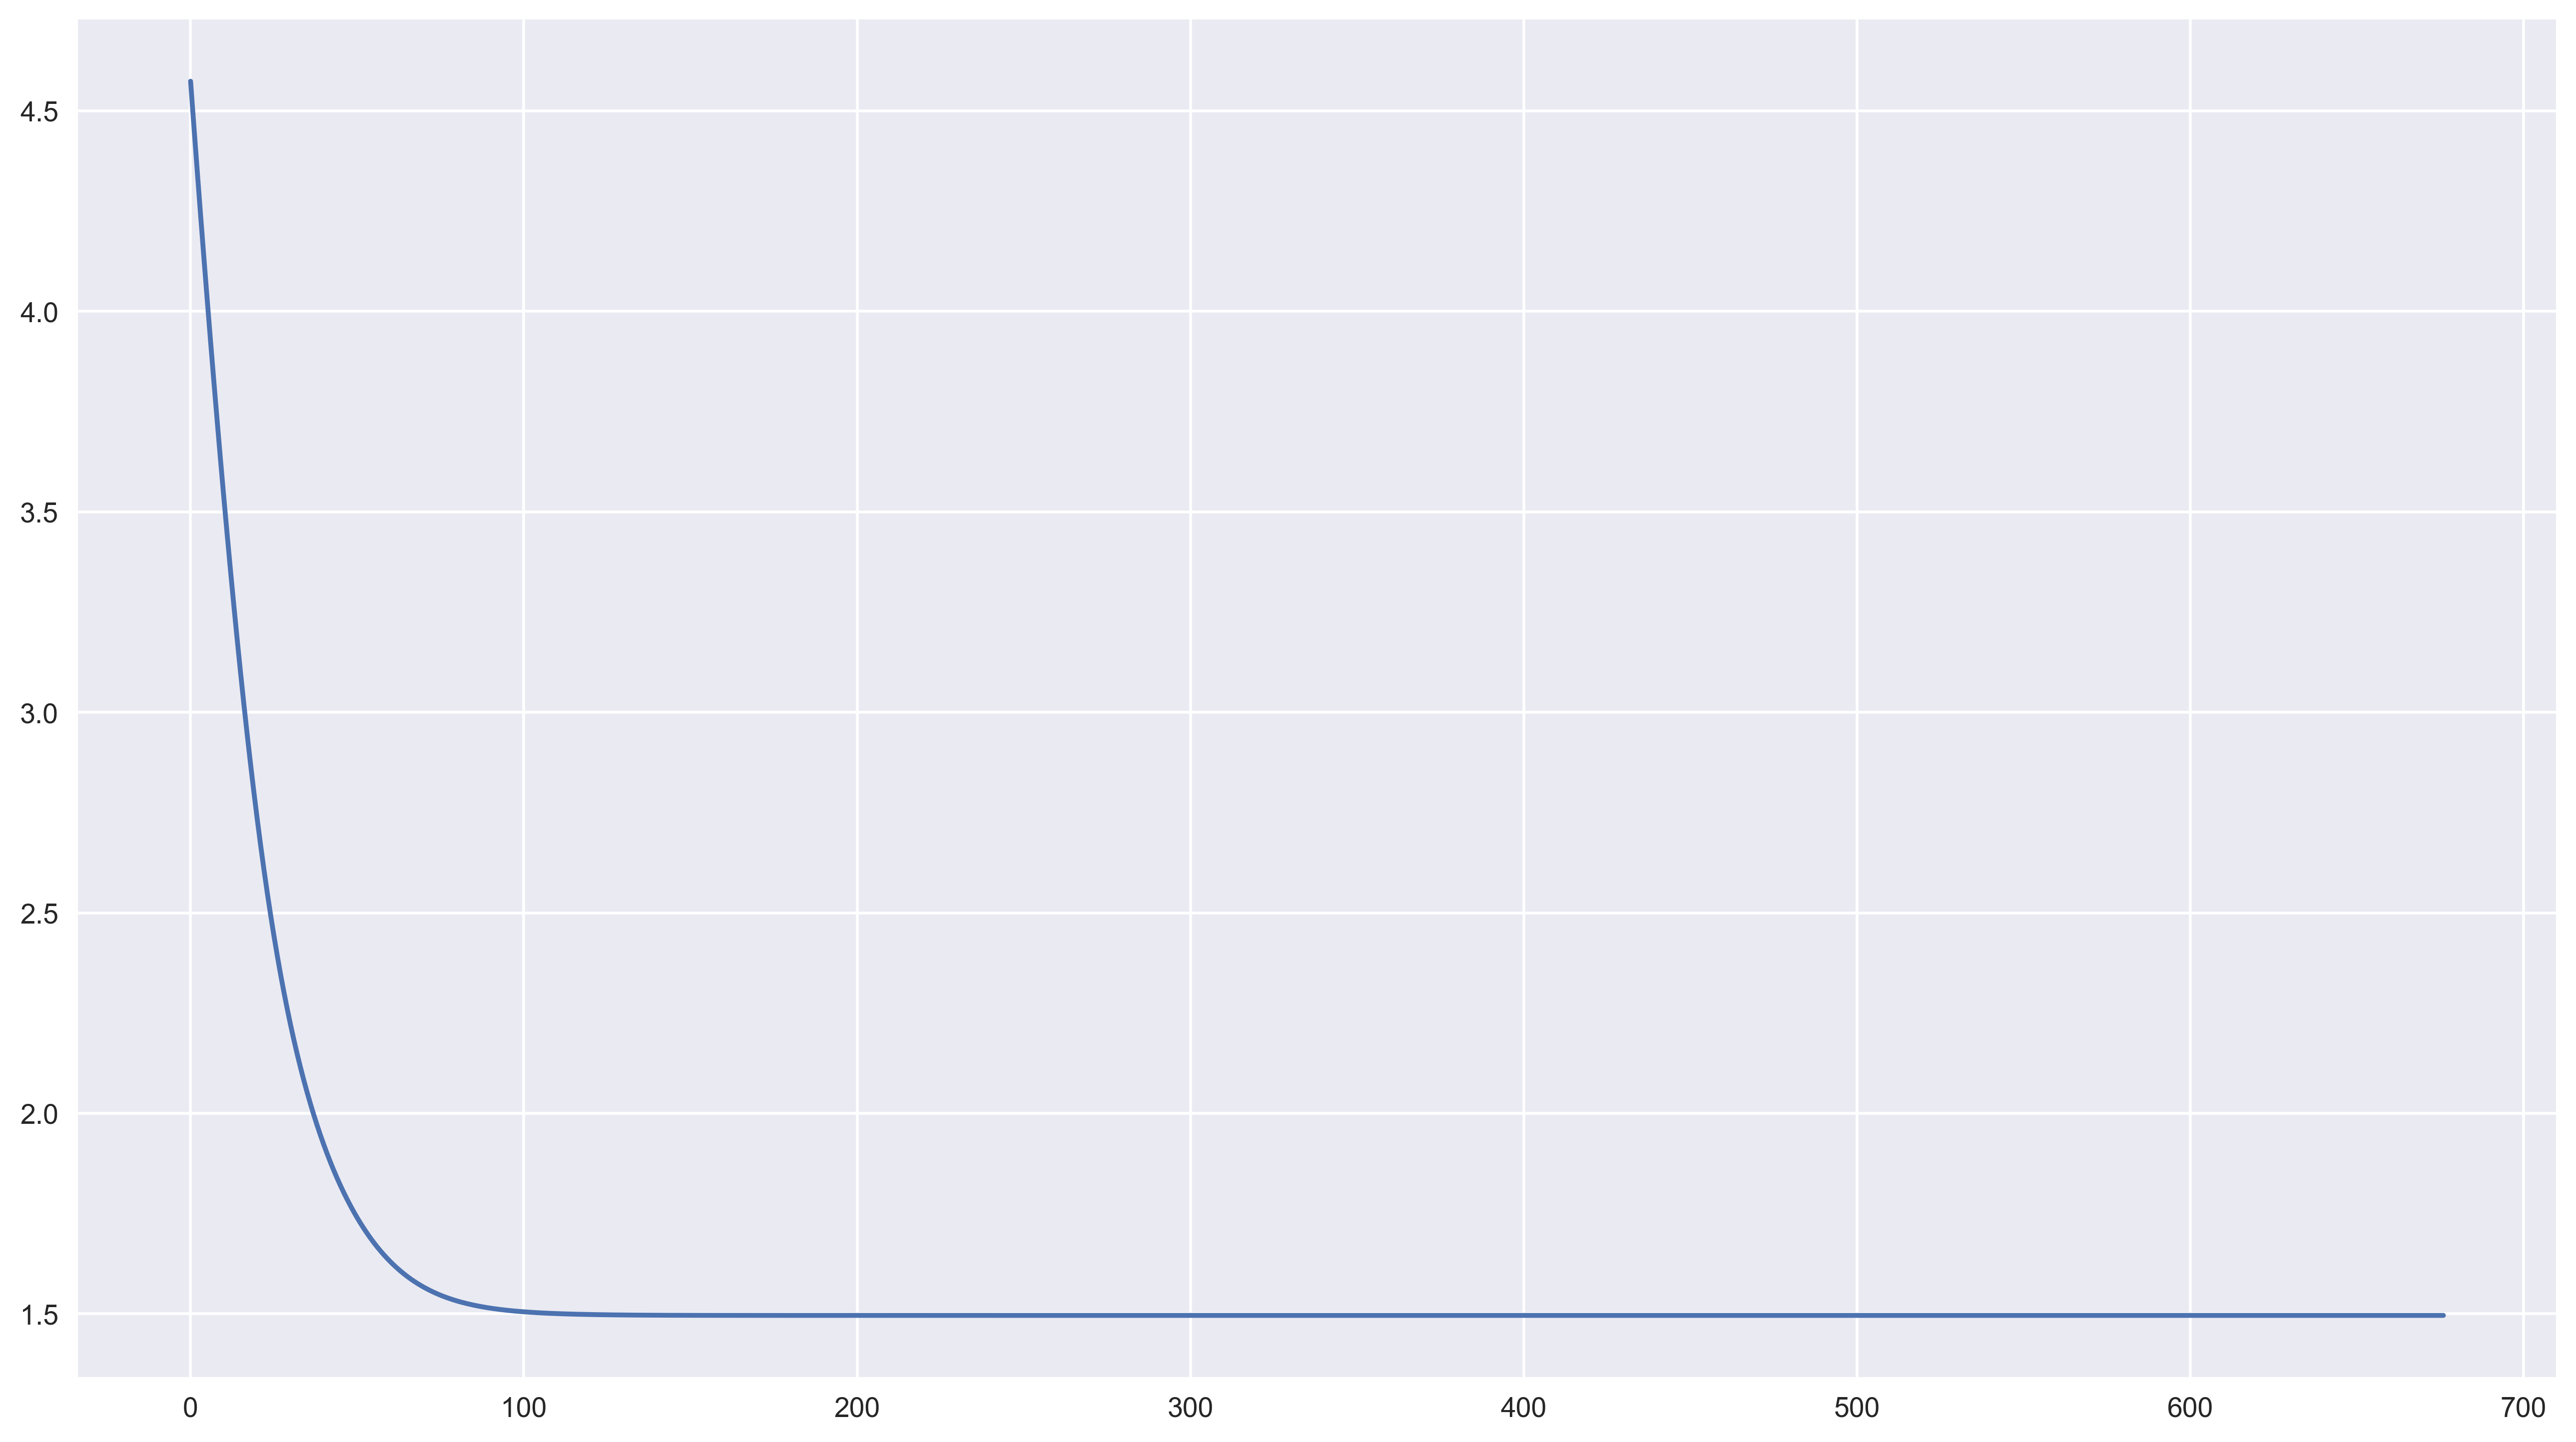

In [371]:
print(theta)
print(optw)
print 'Objective at theta %f and at orginal weights %f' % (objective_function(theta, S), objective_function(optw, S))
print 'Gradient at theta: %.16f' % np.linalg.norm(gradient_fun(theta, S))
plt.plot(np.log10(error))
plt.show()

## Adagrad

In [372]:
theta = rnd.normal(size = 5)*rnd.randint(-50, 50, size = 5)# + rnd.normal(size = 5)*50
error = [objective_function(theta, S)]
gradient_fun = objective_function_gradient
learningRate = 100
gradientHistory = np.zeros_like(theta)
epsilon = 1e-8
maxIter = 1000

t = time.time()
condition = True
niter = 0
while condition:
    # Batch gradient computes gradient based on the whole data set
    gradient = gradient_fun(theta, S)
    gradientHistory += (gradient**2)
    theta -= (learningRate/np.sqrt(gradientHistory + epsilon))*gradient
    niter += 1
    error.append(objective_function(theta, S))
    
    condition = not (np.isclose(0., np.linalg.norm(gradient)) or niter > maxIter)
print 'Computed %d iterations in %s seconds.' % (niter, (time.time() - t))


Computed 105 iterations in 0.615000009537 seconds.


[ -5.76093302 -10.14808163  -2.89947655  -0.97801981   4.9277796 ]
[ -6. -10.  -3.  -1.   5.]
Objective at theta 31.341365 and at orginal weights 35.207165
Gradient at theta: 0.0000000061239109


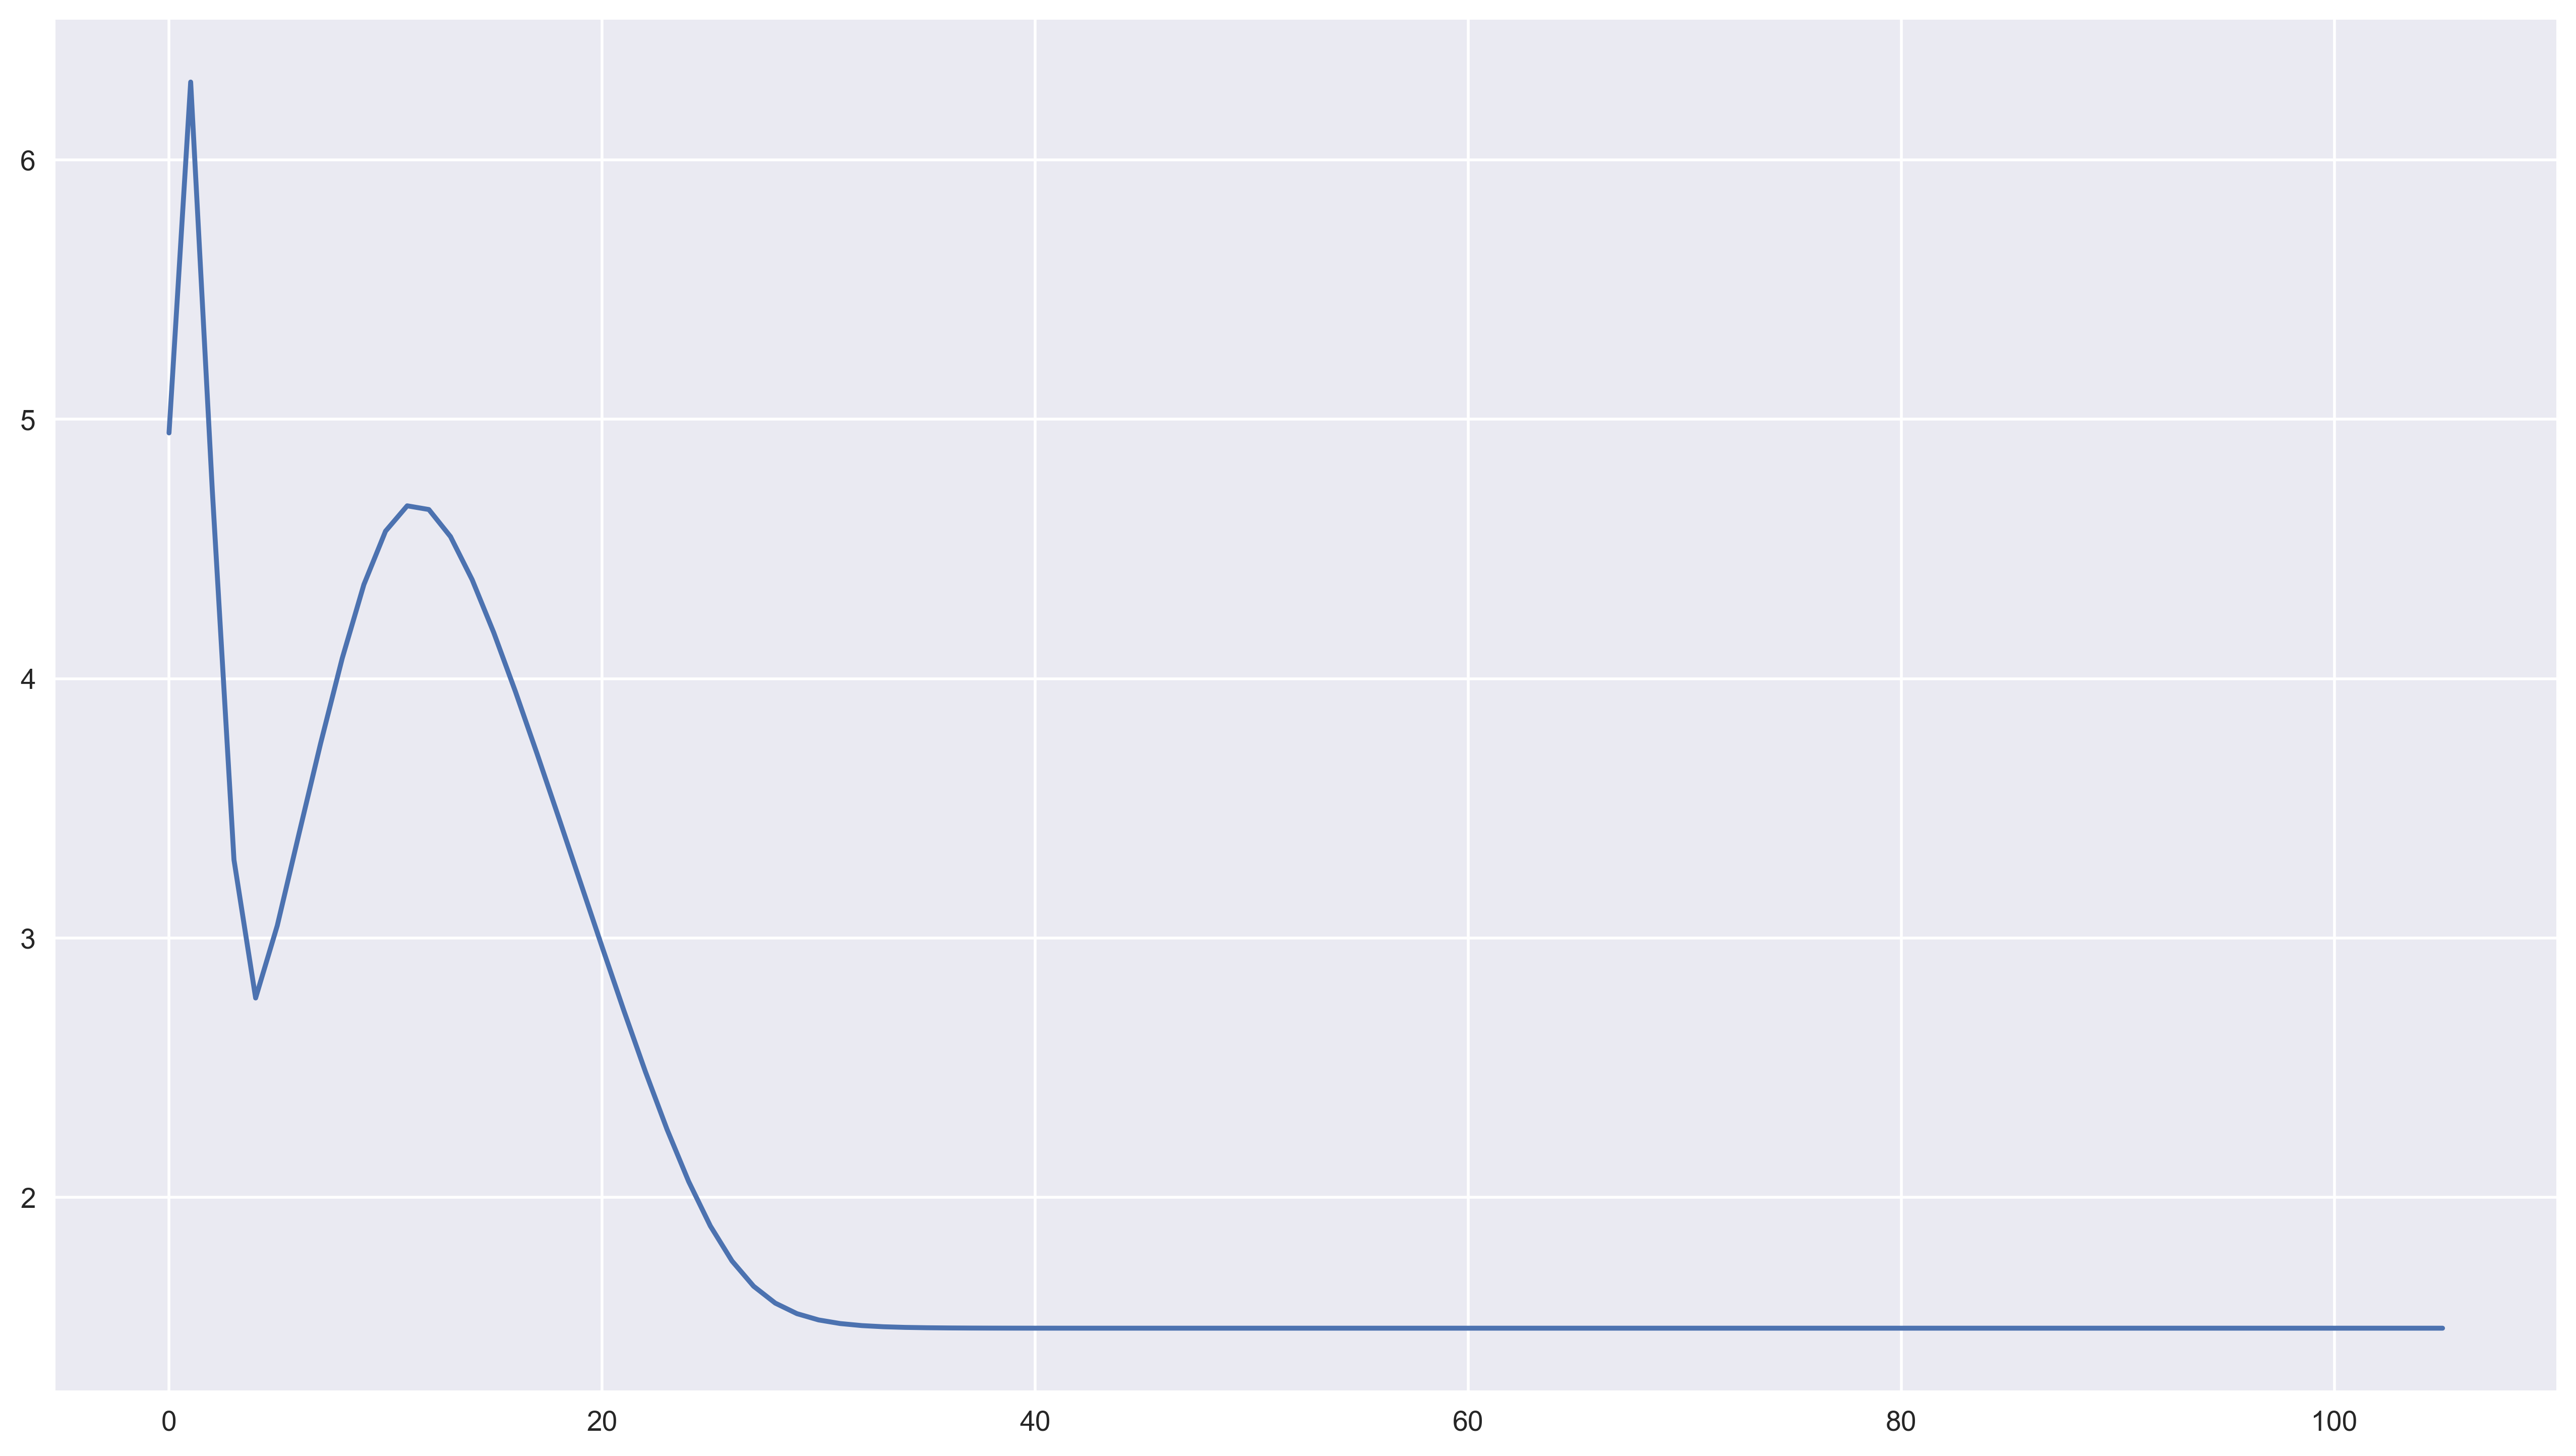

In [373]:
print(theta)
print(optw)
print 'Objective at theta %f and at orginal weights %f' % (objective_function(theta, S), objective_function(optw, S))
print 'Gradient at theta: %.16f' % np.linalg.norm(gradient_fun(theta, S))
plt.plot(np.log10(error))
plt.show()

## Adadelta

Naive computation using window size

In [374]:
theta = rnd.normal(size = 5)*rnd.randint(-50, 50, size = 5)# + rnd.normal(size = 5)*50
error = [objective_function(theta, S)]
gradient_fun = objective_function_gradient
learningRate = 1
windowSize = 100
gamma = 0.999
gradientHistory = np.zeros((len(theta), windowSize))
epsilon = 1e-8
maxIter = 1000

t = time.time()
condition = True
niter = 0
while condition:
    # Batch gradient computes gradient based on the whole data set
    gradient = gradient_fun(theta, S)
    gradientHistory = np.roll(gradientHistory, 1)
    gradientHistory[:, 0] = gradient
    correctionTerm = (gradientHistory**2).mean(axis = 1)
    #print correctionTerm
    theta -= (learningRate/np.sqrt(correctionTerm + epsilon))*gradient
    niter += 1
    error.append(objective_function(theta, S))
    
    condition = not (np.isclose(0., np.linalg.norm(gradient)) or niter > maxIter)
print 'Computed %d iterations in %s seconds.' % (niter, (time.time() - t))


Computed 208 iterations in 1.06500005722 seconds.


[ -5.76093302 -10.14808163  -2.89947655  -0.97801981   4.9277796 ]
[ -6. -10.  -3.  -1.   5.]
Objective at theta 31.341365 and at orginal weights 35.207165
Gradient at theta: 0.0000000114558062


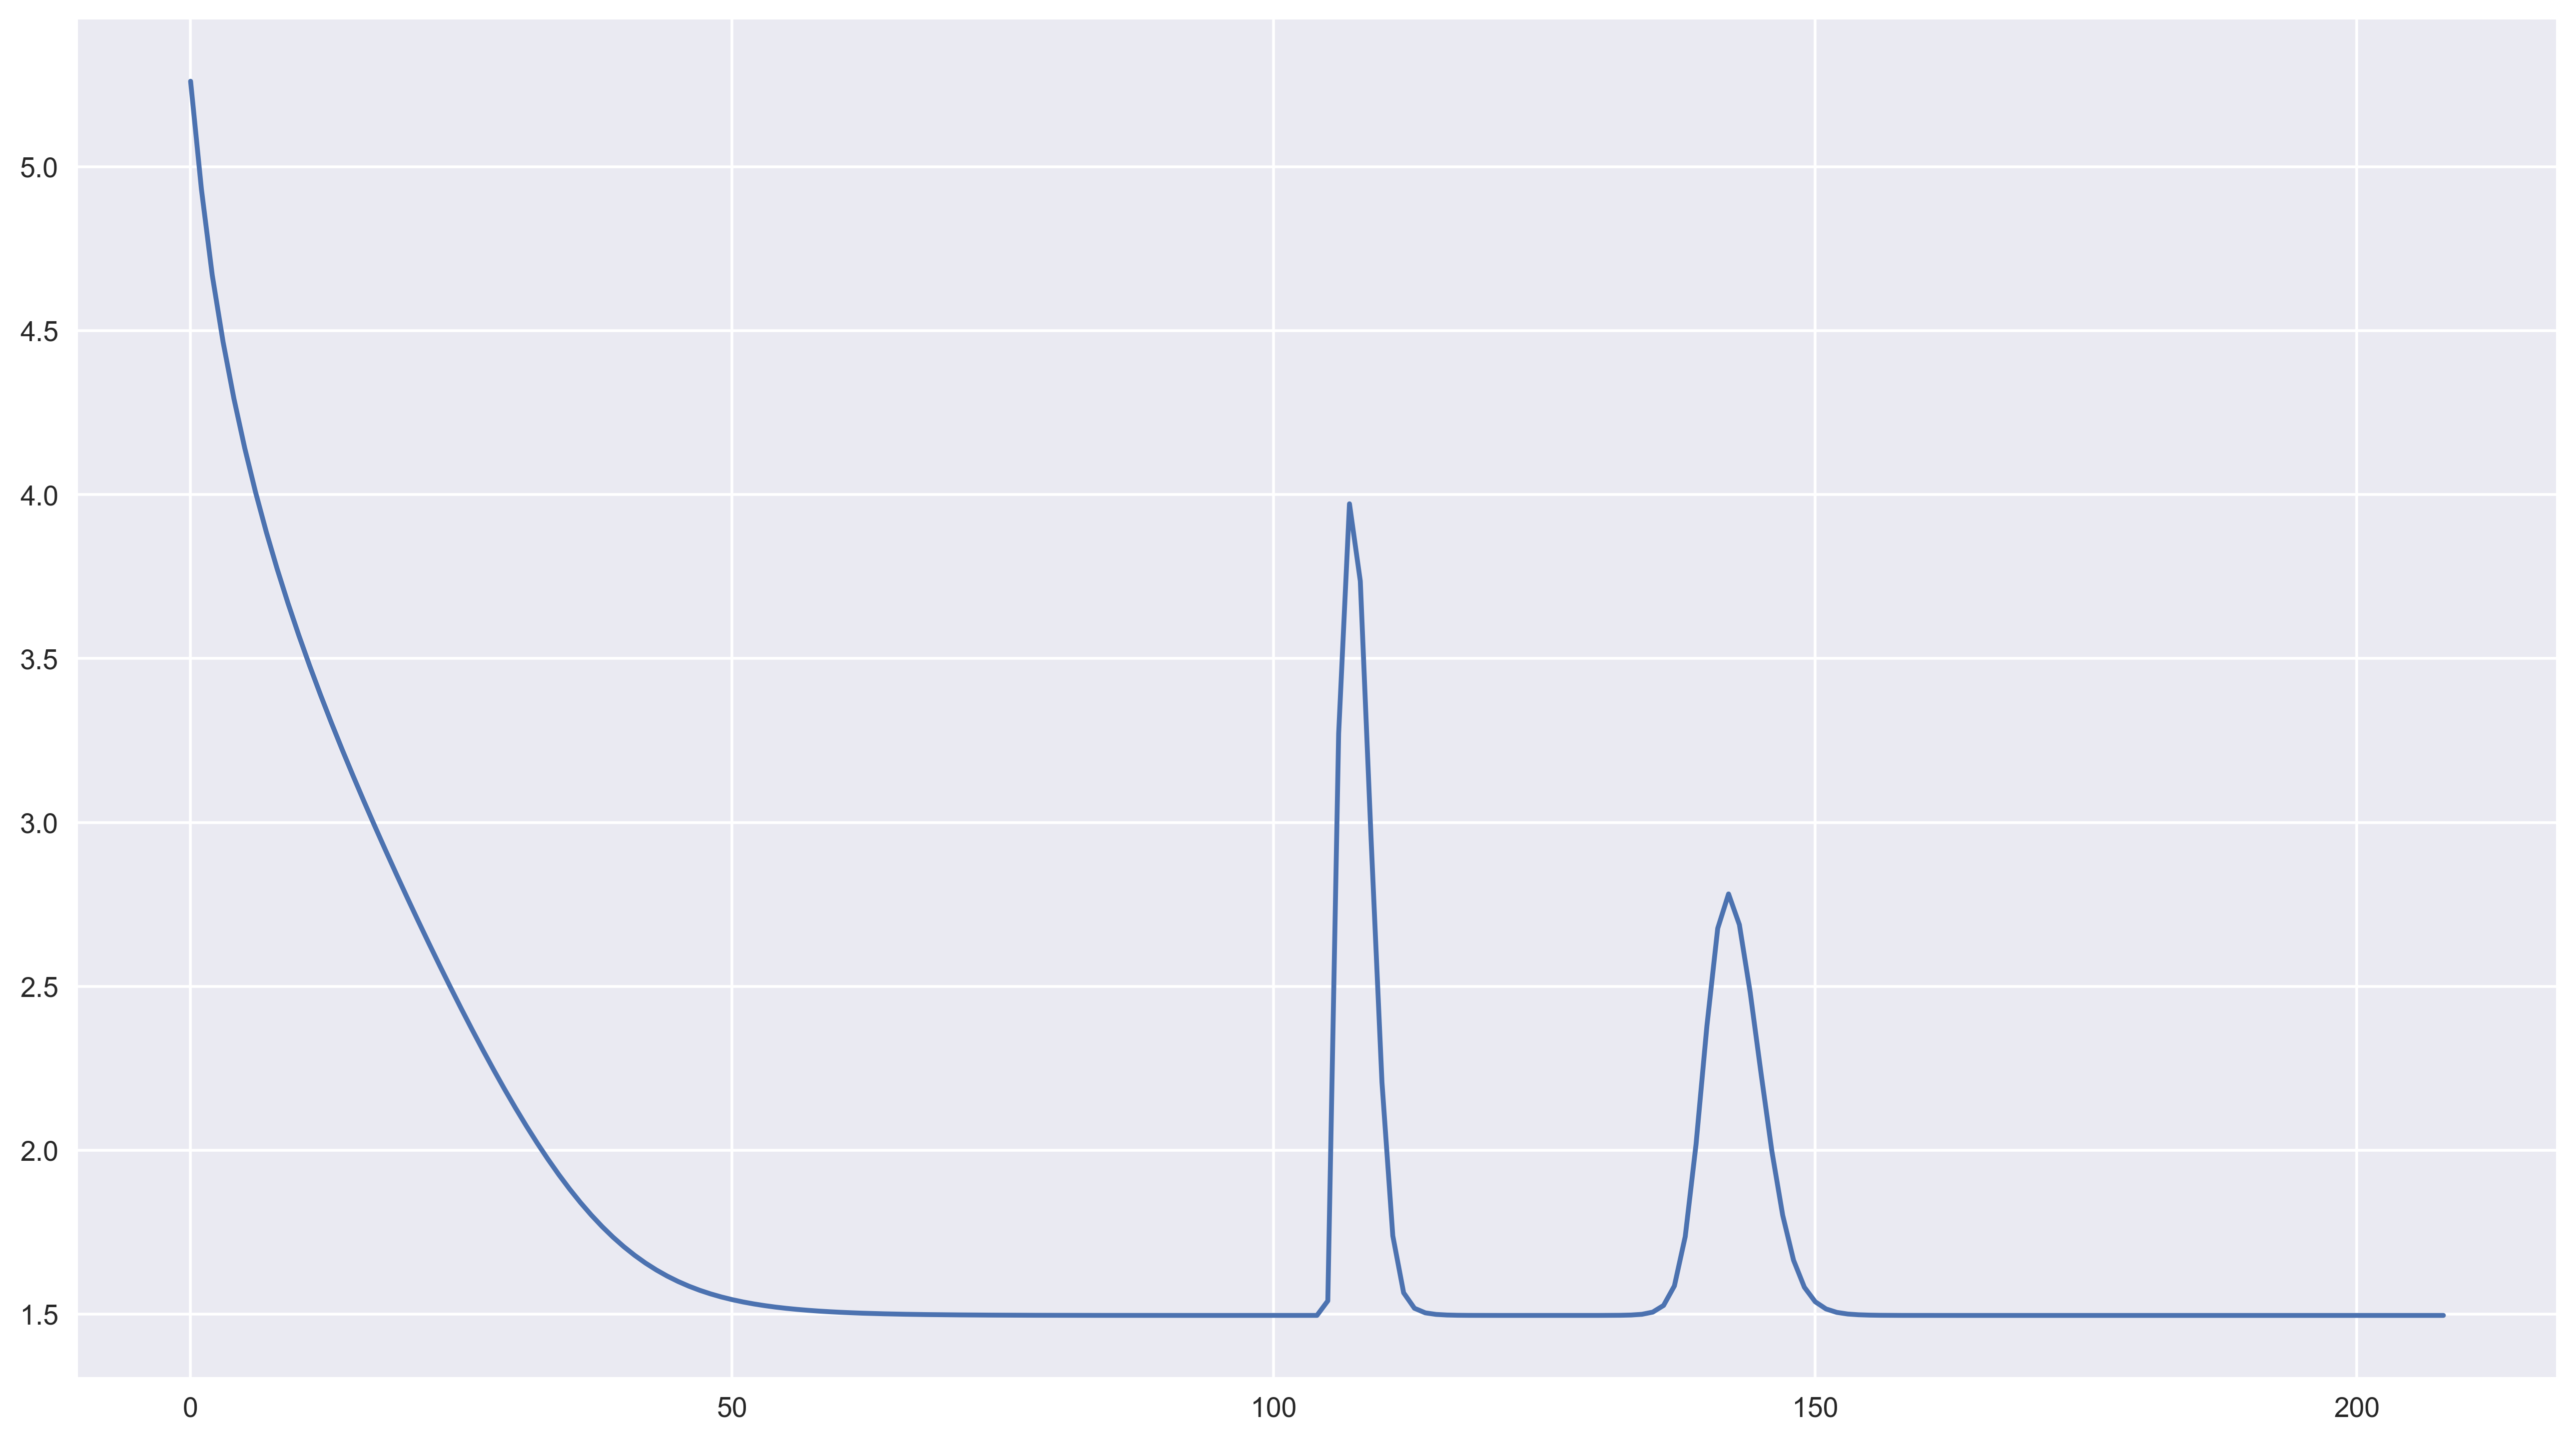

In [375]:
print(theta)
print(optw)
print 'Objective at theta %f and at orginal weights %f' % (objective_function(theta, S), objective_function(optw, S))
print 'Gradient at theta: %.16f' % np.linalg.norm(gradient_fun(theta, S))
plt.plot(np.log10(error))
plt.show()

Implementation using  decaying average

In [376]:
theta = rnd.normal(size = 5)*rnd.randint(-50, 50, size = 5)# + rnd.normal(size = 5)*50
error = [objective_function(theta, S)]
gradient_fun = objective_function_gradient
learningRate = 1#0.1
gamma = 0.999
previousGradient = np.zeros_like(theta)
epsilon = 1e-8
maxIter = 1000

t = time.time()
condition = True
niter = 0
while condition:
    # Batch gradient computes gradient based on the whole data set
    gradient = gradient_fun(theta, S)
    previousGradient = gamma*previousGradient + (1 - gamma)*((learningRate*gradient)**2)
    #print correctionTerm
    theta -= (learningRate/np.sqrt(previousGradient + epsilon))*gradient
    niter += 1
    error.append(objective_function(theta, S))
    
    condition = not (np.isclose(0., np.linalg.norm(gradient)) or niter > maxIter)
print 'Computed %d iterations in %s seconds.' % (niter, (time.time() - t))


Computed 91 iterations in 0.540000200272 seconds.


[ -5.76093302 -10.14808163  -2.89947655  -0.97801981   4.9277796 ]
[ -6. -10.  -3.  -1.   5.]
Objective at theta 31.341365 and at orginal weights 35.207165
Gradient at theta: 0.0000000069885011


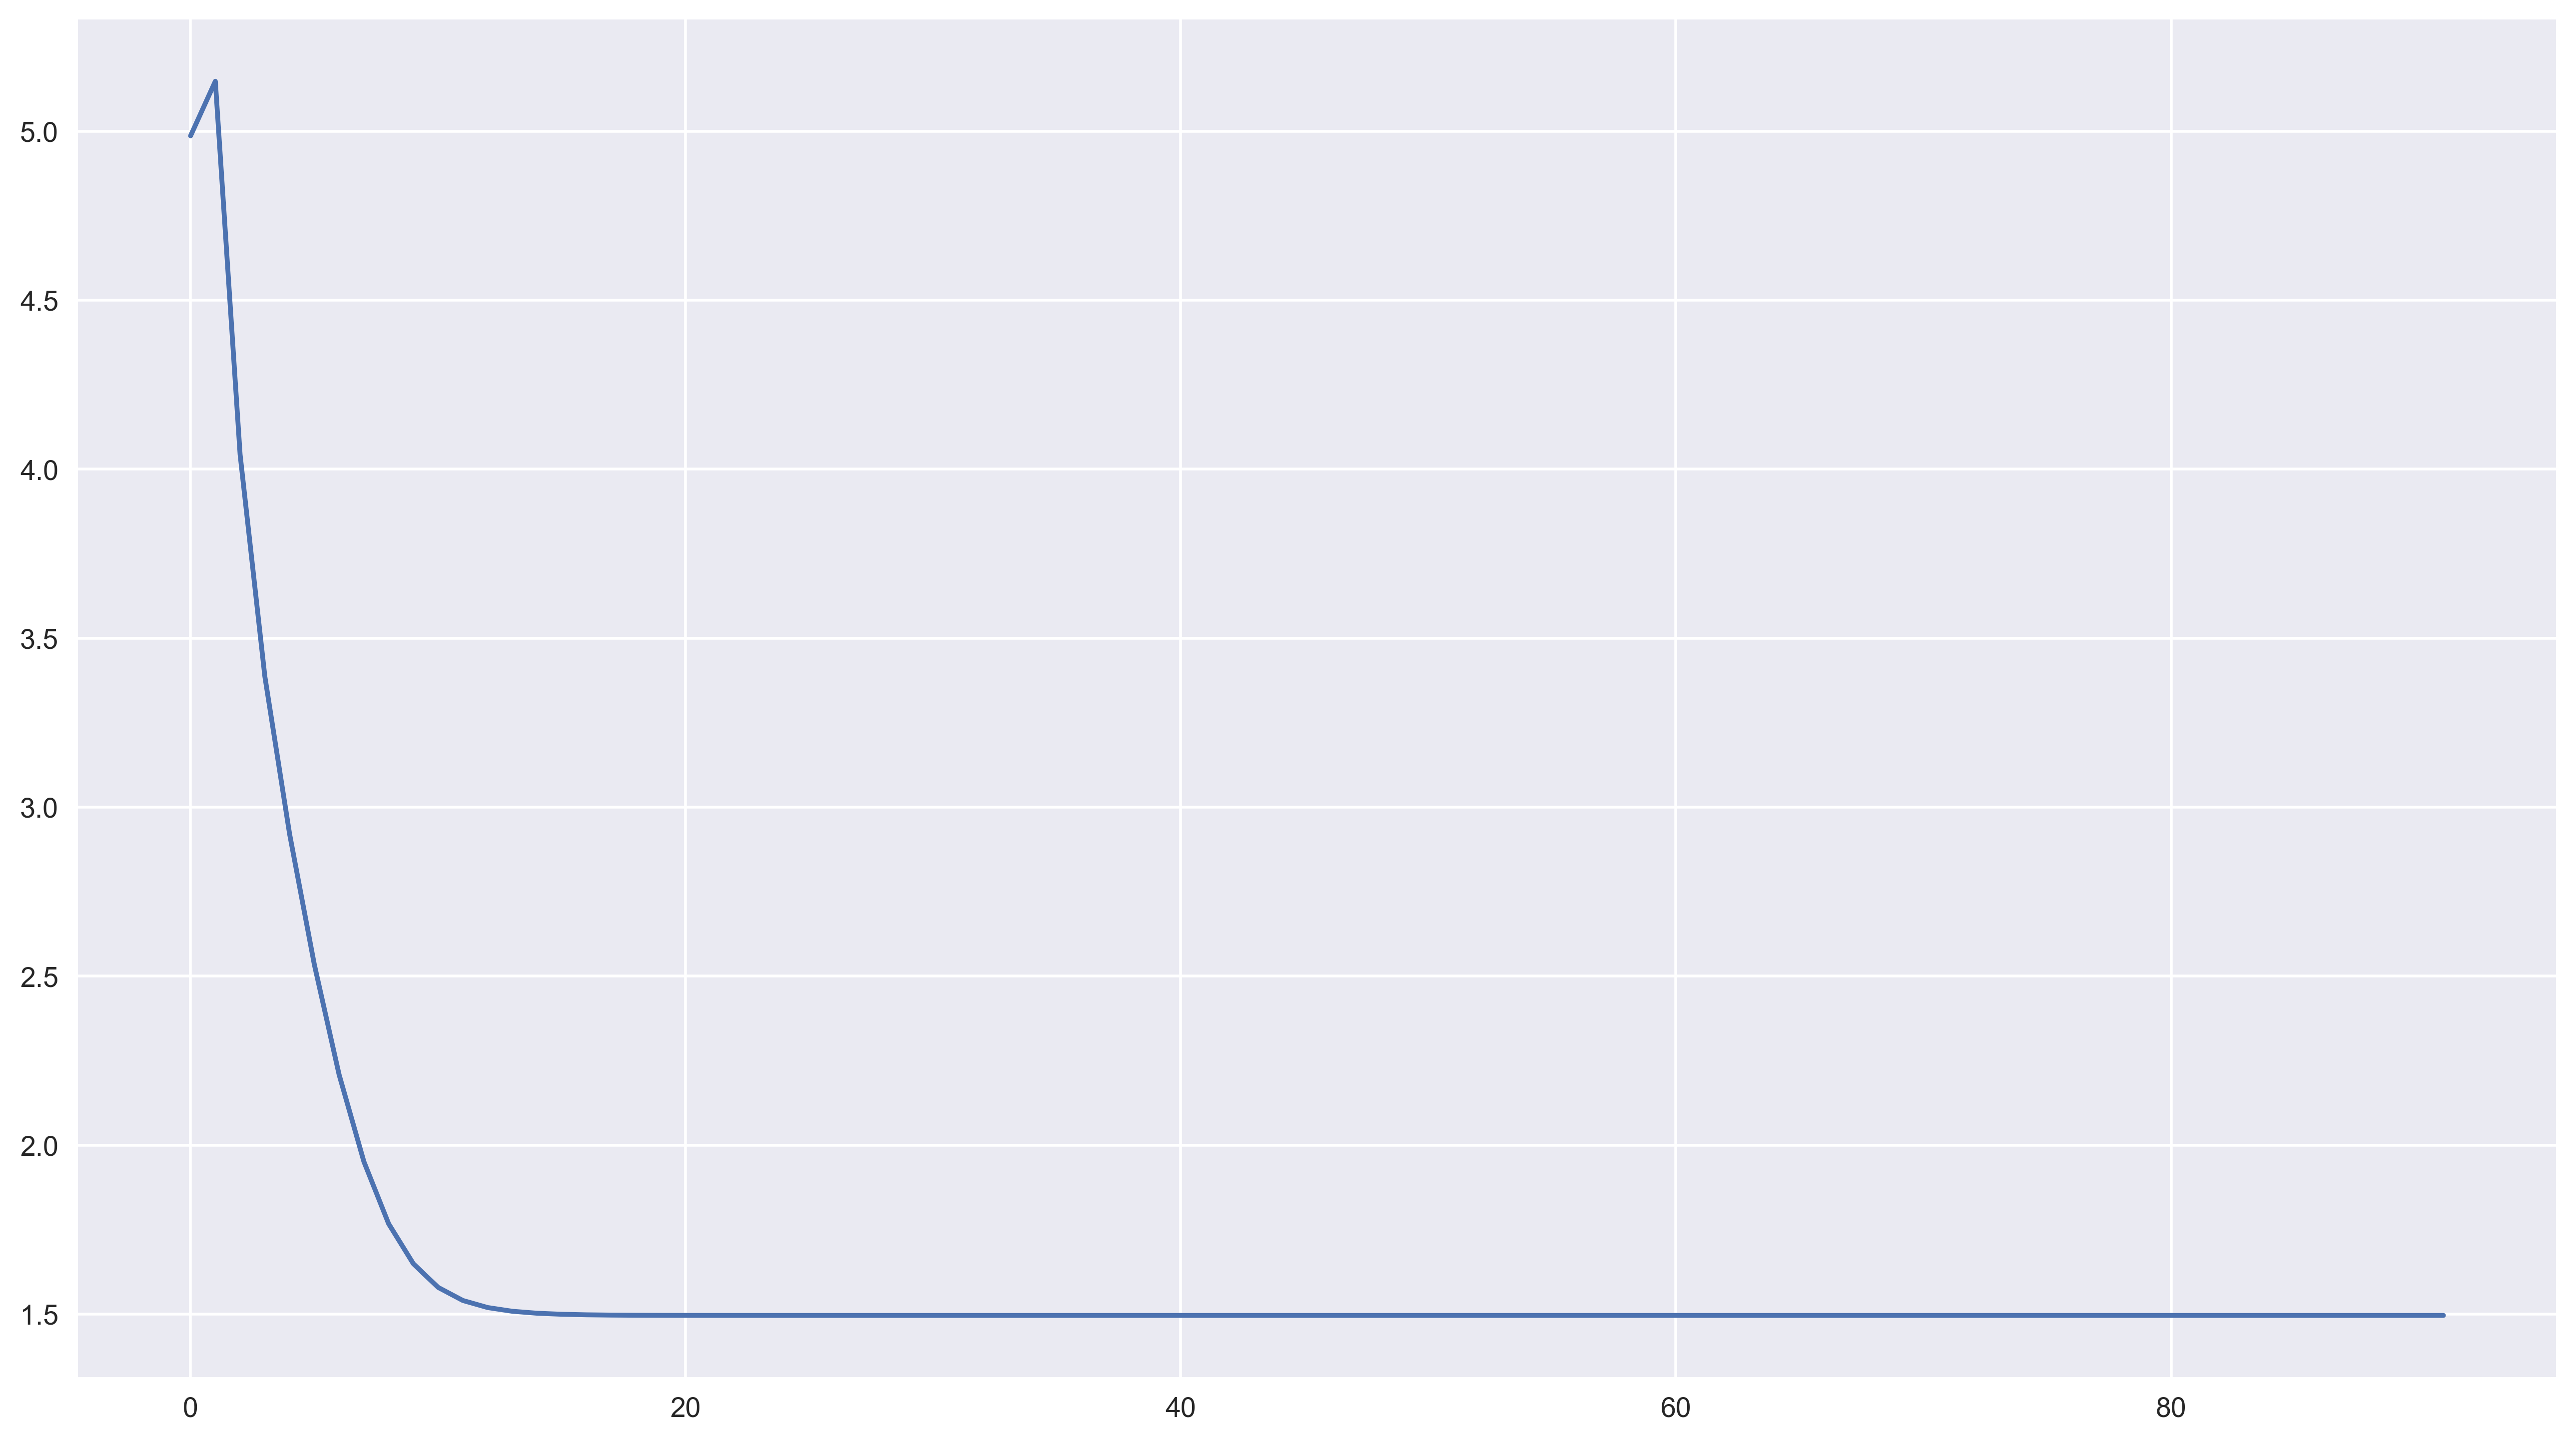

In [377]:
print(theta)
print(optw)
print 'Objective at theta %f and at orginal weights %f' % (objective_function(theta, S), objective_function(optw, S))
print 'Gradient at theta: %.16f' % np.linalg.norm(gradient_fun(theta, S))
plt.plot(np.log10(error))
plt.show()

## Adam

Additionally adaps momentum for each parameter.

In [13]:
theta = rnd.normal(size = 5)*rnd.randint(-50, 50, size = 5)# + rnd.normal(size = 5)*50
error = [objective_function(theta, S)]
gradientNorm = list()
gradient_fun = objective_function_gradient
learningRate = 1#0.1
beta1 = 0.9
beta2 = 0.999
m = np.zeros_like(theta)
v = np.zeros_like(theta)
epsilon = 1e-8
maxIter = 1000

t = time.time()
condition = True
niter = 0
while condition:
    niter += 1
    gradient = gradient_fun(theta, S)
    m = beta1*m + (1 - beta1)*gradient
    v = beta2*v + (1 - beta2)*(gradient**2)
    mt = m/(1. - beta1**niter)
    vt = v/(1. - beta2**niter)
    theta -= ((learningRate*mt)/(np.sqrt(vt) + epsilon)) # <- no gradient term
    error.append(objective_function(theta, S))
    gradientNorm.append(np.linalg.norm(gradient))
    condition = not (np.isclose(0., np.linalg.norm(gradient)) or niter > maxIter)
print 'Computed %d iterations in %s seconds.' % (niter, (time.time() - t))

Computed 480 iterations in 2.56900000572 seconds.


[ 5.79640578 -3.91120531  1.01974346  2.70726387  3.02171804]
[ 6. -4.  1.  3.  3.]
Objective at theta 64.158947 and at orginal weights 68.613724
Gradient at theta: 0.0000000058480965


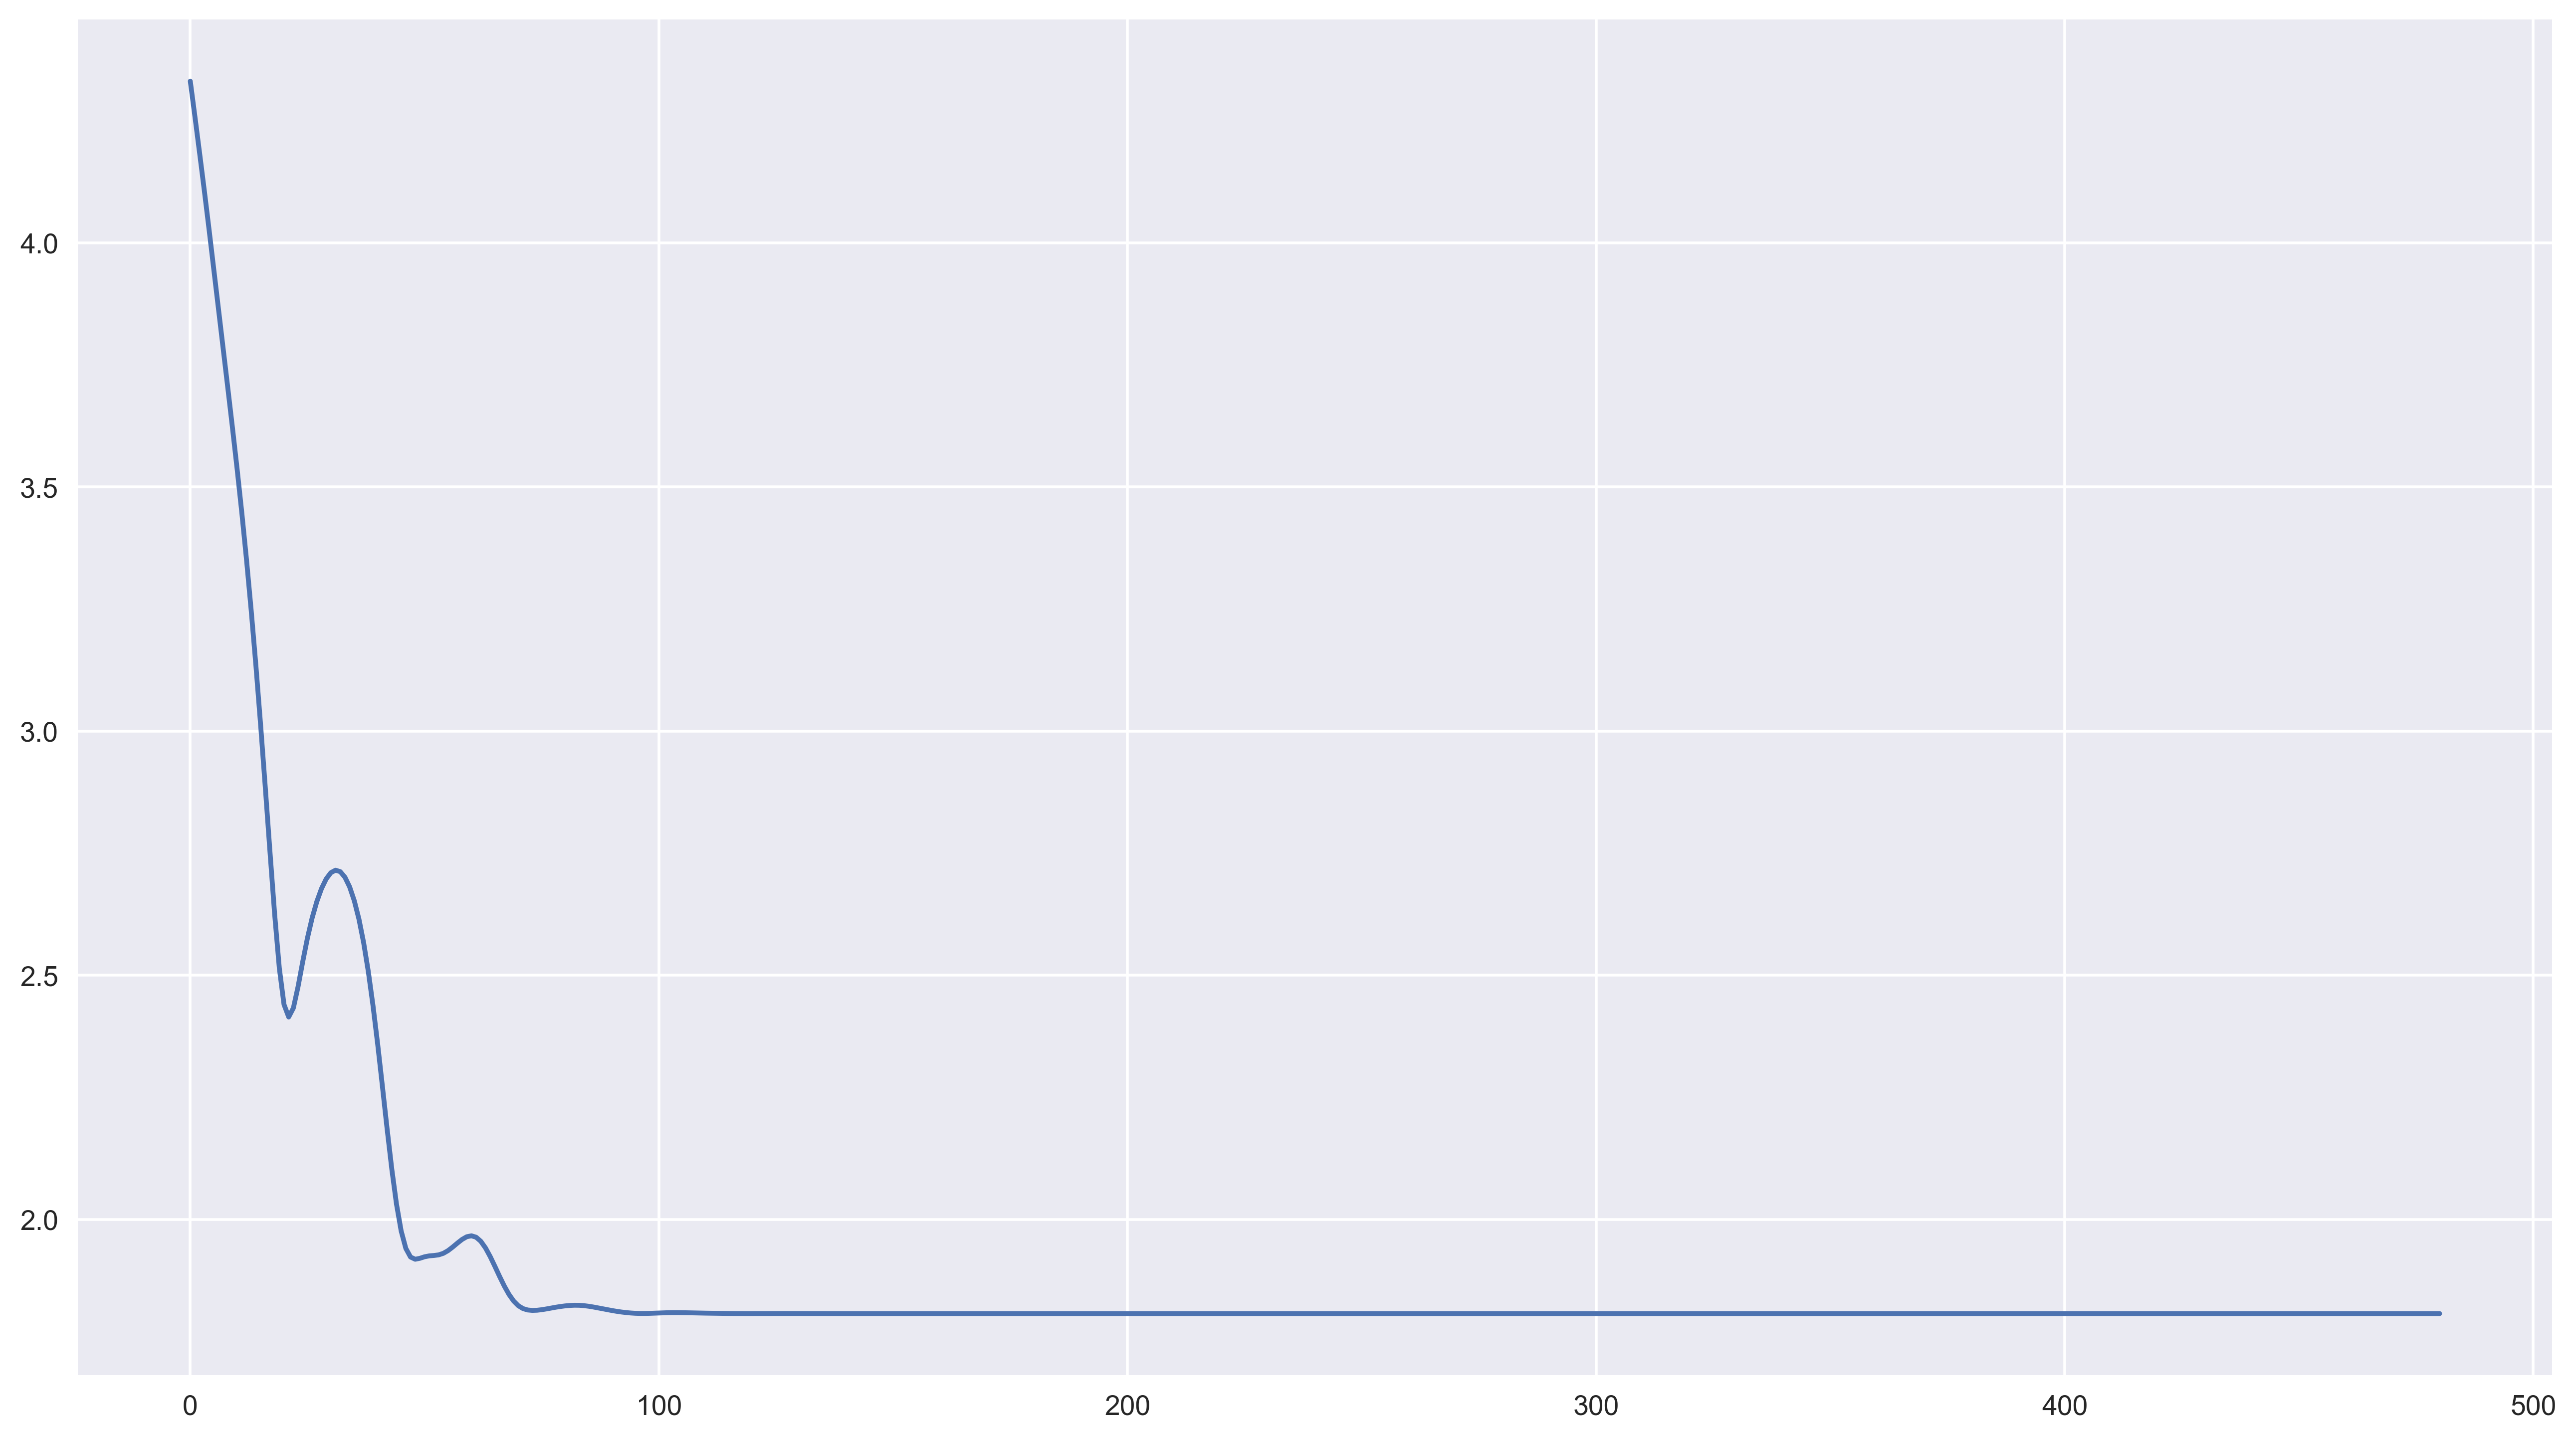

In [14]:
print(theta)
print(optw)
print 'Objective at theta %f and at orginal weights %f' % (objective_function(theta, S), objective_function(optw, S))
print 'Gradient at theta: %.16f' % np.linalg.norm(gradient_fun(theta, S))
plt.plot(np.log10(error))
plt.show()

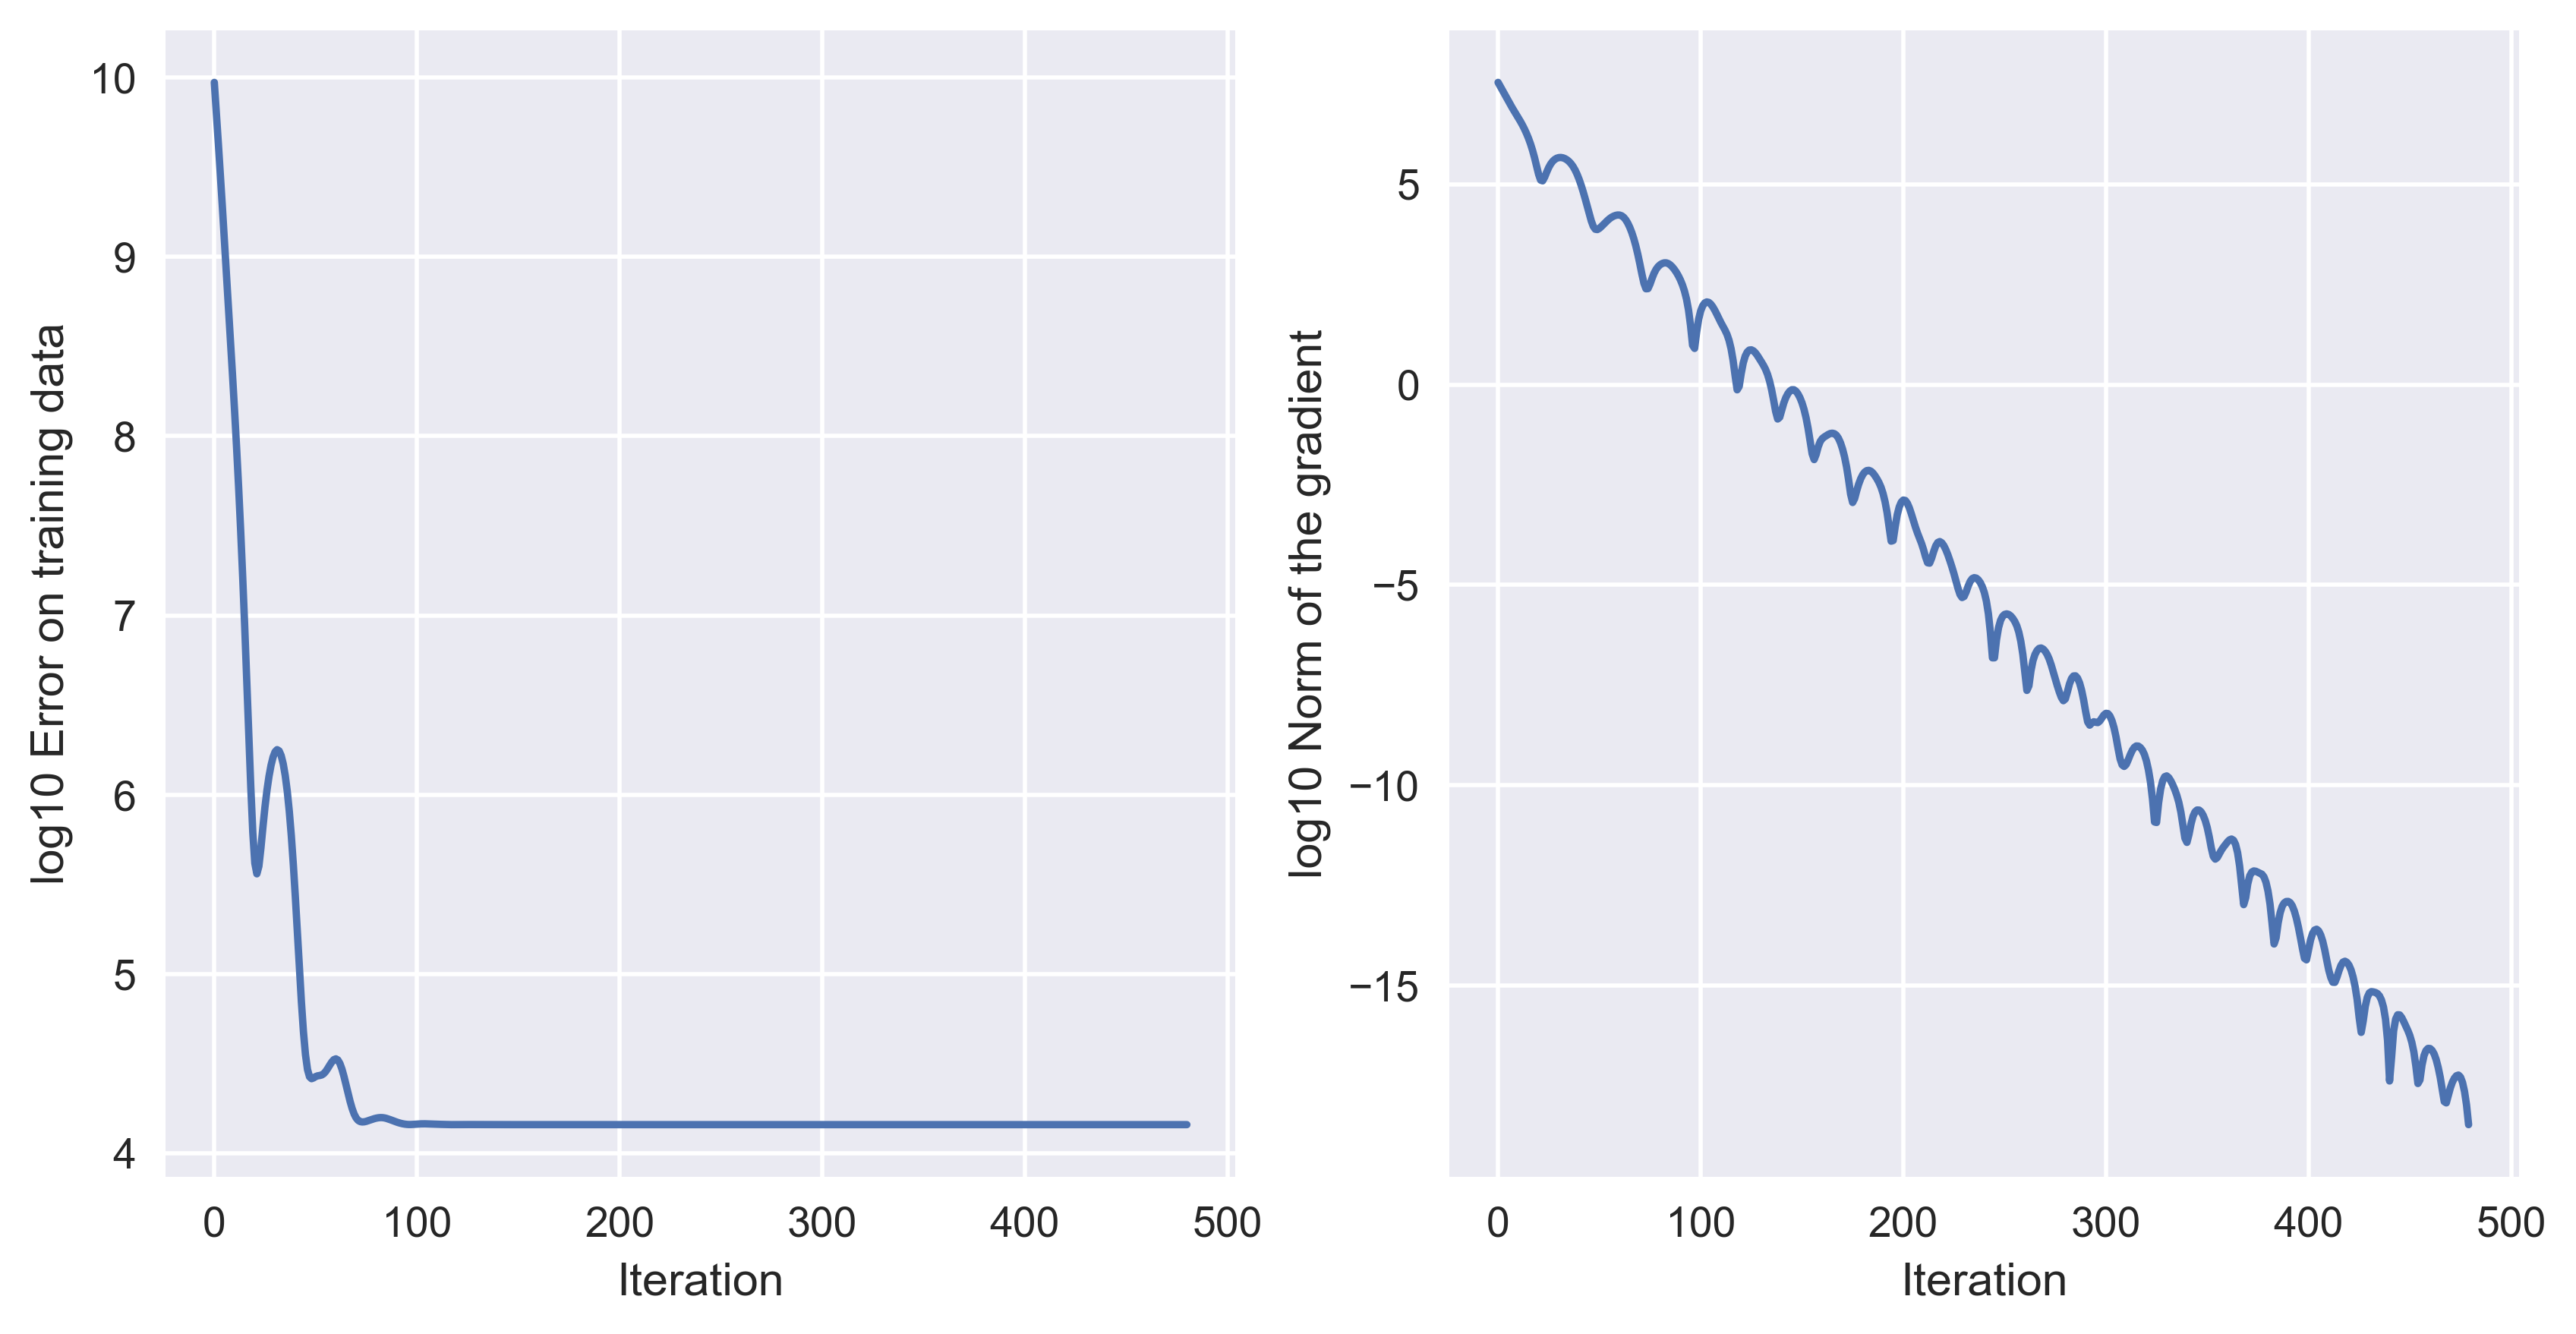

In [15]:
f, axes = plt.subplots(1, 2, sharex=True, sharey=False, figsize=(10, 5))
axes[0].plot(np.log(error))
axes[0].set_ylabel('log10 Error on training data')
axes[0].set_xlabel('Iteration')
axes[1].plot(np.log(gradientNorm))
axes[1].set_ylabel('log10 Norm of the gradient')
axes[1].set_xlabel('Iteration')
plt.show()

# Code optimization

## Differentiation

In [ ]:
# Maybe it can be imporoved by moving away the data
class SimpleModel(object):
    
    def __init__(self, S):
        self.x, self.y = zip(*S)
        self.objective_gradient = grad(self.objective)
        
    def model(self, weights):
        return np.array([weights[0] + np.sum(x*weights[1:]) for x in self.x])
        
    def objective(self, theta):
        return np.sum((self.model(theta) - self.y)**2)
        
sm = SimpleModel(S)
print objective_function(theta, S)
print sm.objective(theta)
print objective_function_gradient(theta, S)
print sm.objective_gradient(theta)
%timeit objective_function_gradient(theta, S)
%timeit sm.objective_gradient(theta)

In [ ]:
def linear_model_m(x, theta):
    return np.dot(x, theta[1:]) + theta[0]

#linear_model_m(xSet, np.array([10000, 1,10,100, 1000]))
def objective_function_m(theta, xMatrix, yValues):
    return np.sum((linear_model_m(xMatrix, theta) - yValues)**2)

# def objective_function_m_gradient(theta, xMatrix, yValues):
#     _x = np.append(np.ones((np.shape(xMatrix)[0], 1)), xMatrix, axis = 1)
#     return 2*np.dot(linear_model_m(xMatrix, theta), _x) - 2*
#     #return np.sum([2*(linear_model_m(xMatrix, theta)*_x) - 2*np.append(1, x)*y for x,y in S], axis = 0)

print x,y
objective_function_m(theta, x, y)

In [ ]:
y = zip(*S)[1]
x = np.array(zip(*S)[0])
print np.shape(x), np.shape(y)
print objective_function_m(optw, x,y)

objective_function(optw, S)
_dx = grad(objective_function)#(optw, S)
print objective_function(optw, S), _dx(theta, S)

In [ ]:
y = zip(*S)[1]
x = np.matrix(zip(*S)[0])
print np.array(x[:6])
_x = np.append(np.ones((np.shape(x)[0], 1)), x, axis = 1)
print linear_model_m(x, theta)[:6]
print _x[:6]
print 2*np.dot(linear_model_m(x, theta), _x)
print (np.array(_x[:6]).T * y[:6]).T
print 2*np.dot(linear_model_m(x, theta), _x) - 2*(np.array(_x).T * y).T

In [ ]:
# #_m = np.array([[1,2,3],[4,5,6],[7,8,9]])
# #_c = np.array([0,1,2])
# #_m * _c
# _m = np.array(xrange(12)).reshape((4,3))
# _c = np.array([10,200,3000,4000])
# print (_m.T * _c).T
# #_m

In [ ]:
x, y = zip(*S)

theta = rnd.normal(size = 5)#rnd.randint(-10, 10, size = 5) + rnd.normal(size = 5)*50
error = [objective_function_m(theta, x, y)]
dx = grad(objective_function_m)
t = time.time()
for epoch in xrange(20):
    rnd.shuffle(S)
    batchSize = 15
    batches = [S[i:i + batchSize] for i in xrange(0, len(S), batchSize)]
    for i in xrange(30):
        for _S in batches:
            x, y = zip(*_S)
            theta -= 0.01*dx(theta, x, y)
            error.append(objective_function_m(theta, x,y))
print 'Computed in %s seconds' % (time.time() - t)

In [ ]:
print(theta)
print(optw)
plt.plot(np.log(error))
plt.show()